# Deep learning MC2 - Neural Image Caption (NIC)

FS 2024 - Data Science - Weiping Zhang

- **Paper:** Show and Tell - A Neural Image Caption Generator

- **Goal:** develop deep learning models (two variant) that can automatically understand the content of an image and generate human-readable descriptions that accurately describe what is happening in the image.

- **Dataset:** flickr8k
- **Deep learning framework:** Pytorch

- Metrics, loss and hyperparameters are tracked on **Weights & Biases**。

In [1]:
import os
import math
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from PIL import Image
import nltk
from nltk.translate.bleu_score import sentence_bleu
import re
import random
import pandas as pd
import numpy as np
from spellchecker import SpellChecker
import wandb
from IPython.display import IFrame
import warnings
warnings.filterwarnings("ignore")
os.environ['WANDB_SILENT'] = "true"  # suppress wandb output info

In [43]:
wandb.login()

True

# 1 Exploratory Data Analysis

In [3]:
# get all image id that end with '.jpg' from the flickr8k/Images folder
img_dir = "flickr8k/Images"
img_ids = [id for id in os.listdir(img_dir) if '.jpg' in id]

# get all captions from the captions.txt file and store them in a list of tuples (image_id, caption)
captions_original = []
with open("flickr8k/captions.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        parts = line.strip().split(',')
        if len(parts) == 2:
            image_id, caption = parts[0], parts[1]
            captions_original.append((image_id, caption))
print(f"The dataset contains {len(img_ids)} images and {len(captions_original)} captions.")

The dataset contains 8091 images and 38009 captions.


The dataset has multi-reference captions for each image, which is very common for image captioning. As different captions may use differnt words or phrases to describe the same image, this is helpful for the models to better understand diverse natural language and for evaluation.

### Display image examples with corresponding captions


Image 2609847254_0ec40c1cce.jpg has 5 captions:

A girl is smiling at the camera with a crowd of people behind her .
A girl with long dark hair wearing a yellow and white shirt is smiling .
A young girl smiling for the camera .
A young smiling girl wearing yellow in a crowd .
Young girl posing with crowd in the background

Image 2270483627_16fe41b063.jpg has 5 captions:

A big tan dog jumps in the water .
A light brown dog is running in the water .
A light colored dog splashes through the water .
A tan dog splashing in water on the bank of a pond or river .
A white dog is splashing through the water .


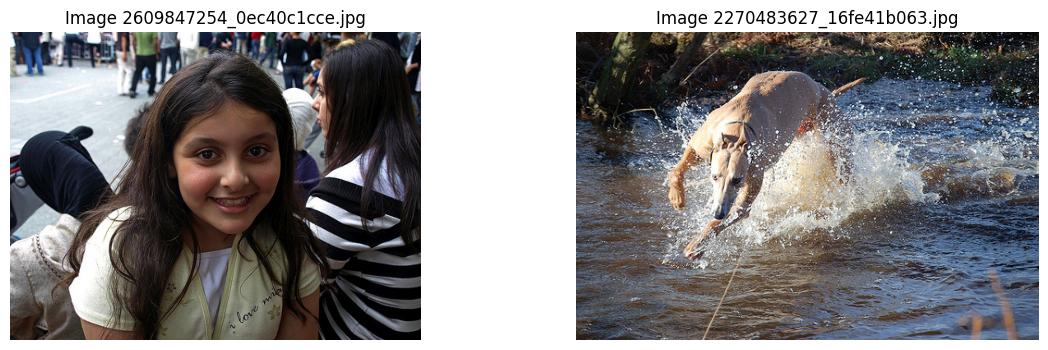

In [4]:
def display_images(img_ids, captions_file):
    '''
    Display images with their captions. 
    img_ids is a list of image ids, 
    captions_file is the file containing the captions of the whole dataset.'''
    fig, axes = plt.subplots(1, len(img_ids), figsize=(14, 4))
    for i, ax in enumerate(axes):
        img_id = img_ids[i]
        img_path = os.path.join(img_dir, f"{img_id}")
        captions = find_caption(img_id, captions_file)
        print(f"\nImage {img_id} has {len(captions)} captions:\n")
        for caption in captions:
            print(f"{caption}")
        ax.imshow(plt.imread(img_path))
        ax.axis("off")
        ax.set_title(f"Image {img_id}")
    plt.show()

def find_caption(image_id, captions_file):
    # find captions for a given image id
    found_captions = []
    for image_id_, caption in captions_file:
        if image_id_ == image_id:
            found_captions.append(caption)
    return found_captions   
       
display_images([img_ids[1], img_ids[50]], captions_original)

- Each caption contains only one sentence.
- Most of the captions start with capital letter and ends with ``.``
- For each image, the five reference captions have different lengths, description styles and focuses, but they all describe the image properly.
- Five reference captions together offer a diverse vocabulary which are relevant to the image.

# 2 Caption & vocabulary preprocessing

For image captioning, a vocabulary is needed for the model to generate captions for the images. Vocabulary should have a comprehensive diversity to describe the images. This is a crucial step, because it will directly impact the model's ability in understanding and generating captions. 

## 2.1 Distribution of vocabulary
Let's take a closer look at the captions: vocabulary diversity, frequency, etc.


The captions contain in total 437919 words; with vocabulary size of 9271.



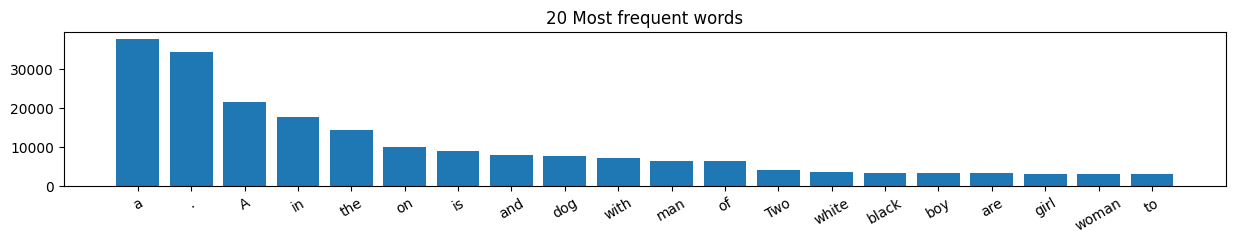

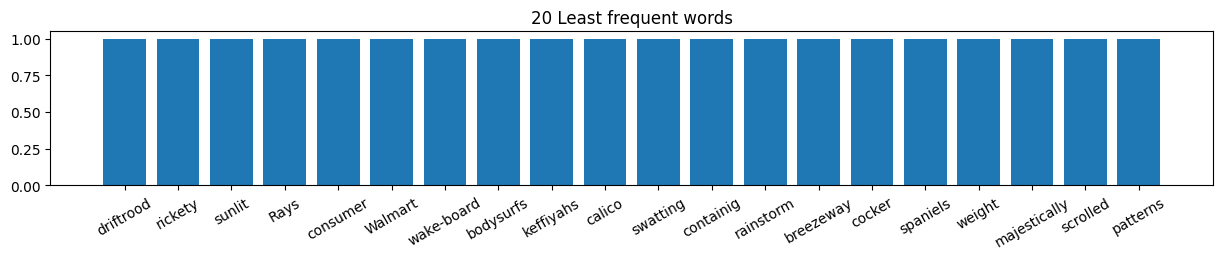

In [5]:
def extract_words_freq(captions):
    '''
    Get all unique words in the captions file with their frequency.
    Return a dictionary, words as key and frequencies as value, sorted by frequency in descending order
    '''
    all_words_lst = []
    for _ , caption in captions:
        words = caption.split()
        all_words_lst.extend(words)

    words_freq_dict= dict(sorted(Counter(all_words_lst).items(), key=lambda x: x[1], reverse=True))
    print(f"\nThe captions contain in total {len(all_words_lst)} words; with vocabulary size of {len(words_freq_dict)}.\n")
    return words_freq_dict
    
def plot_frequent_words(words_freq_dict, start, end, title):
    """ plot words with frequencies """
    words_freq_lst = list(words_freq_dict.items())[start:end]
    words = [word for word, _ in words_freq_lst]
    counts = [count for _, count in words_freq_lst]
    plt.figure(figsize=(15, 2))
    plt.bar(words, counts)
    plt.title(title)
    plt.xticks(rotation=30)
    plt.show() 


words_freq_dict = extract_words_freq(captions_original)
plot_frequent_words(words_freq_dict,0, 20, "20 Most frequent words")
plot_frequent_words(words_freq_dict,-20, len(words_freq_dict), "20 Least frequent words")


- The most frequent words are mainly function words. They are important for sentence structure but carry little semantic information about the content.
- Words 'dog', 'man', 'boy', 'girl', 'woman' are high frequency word. This suggests the dataset mightbe predominantly involving dogs and people. 
- Presence of both 'a' and 'A' indicates the captions are not case formatted.
- Many words have appeared only once. Some are due to misspellings (e.g. containig). 

## 2.2 Select pretrained word embedding model

-   For the first deep learning model, I would use the pretrained embeddings to reduce the training effort. 

-   My first selection was pretrained word2vec model provided by Google (GoogleNews-vectors-negative300), which is trained on google news dataset. It contains around 3 million words and phrases, where each word is represented by a 300 dimensional vector. However, it is suitable for this project, as it doesn't contain the stop words like "a", "the", "and", which appear very high frequently in my captions file. 

-   I will check if GloVe pretrained model could well cover the vocabulary in my captions file. GloVe is pretrained on large corpora, the embeddings could capture a wide range of semantic relationships. GloVe has embedding models in various dimensions (50,100,200,...), which allows to choose the suitable models that could best balance the performance and computational efficiency. I will start with glove.6B.200d (and 100d), which has a vocabulary size of ~400,000 words and the vector dimension of 200 (100). This model is trained on about 6 billion tokens from wikipedia 2014 and Gigaword 5.

In [6]:
def load_txt_embeddings(embeddings_txt):
    embeddings_dict = {}
    with open(embeddings_txt, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict
    
glove_100 = load_txt_embeddings('glove.6B.100d.txt')
glove_200 = load_txt_embeddings('glove.6B.200d.txt')
glove_word_lst = list(glove_100.keys())
len(glove_word_lst)

400000

### How good could GloVe embeddings cover the vocabulary of my dataset?

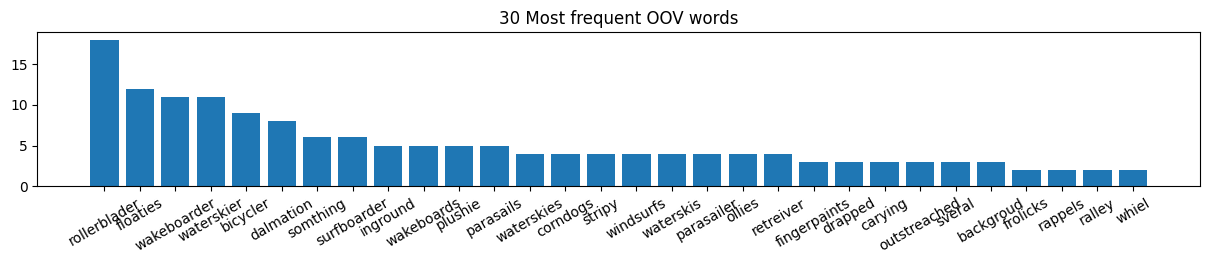

621 vocabulary words (total frequency 775) are not covered by GloVe embeddings


In [7]:
def modify_str(string):
    # replace non-alphanumeric characters with space
    string = re.sub(r'[^a-zA-Z0-9_]', ' ', string)
    # remove extra spaces and the spaces at the end
    string = re.sub(r'\s+', ' ', string).strip()
    # lower case
    string = string.lower()
    return string


# extract the out-of-vocabulary (of glove) words from the captions
oov_lst = [word for _, caption in captions_original for word in modify_str(caption).split() if word not in glove_word_lst]
oov_freq_dict = dict(sorted(Counter(oov_lst).items(), key=lambda item: item[1], reverse=True))

plot_frequent_words(oov_freq_dict,0, 30, "30 Most frequent OOV words")
print(f"{len(oov_freq_dict)} vocabulary words (total frequency {sum(oov_freq_dict.values())}) are not covered by GloVe embeddings")

-   Glove embeddings include the majority of my vocabulary, however quite some minority sports relevant words (e.g. wakeboarder, surboarder, waterskis) are not contained. And as mentioned previously, some words have spelling errors (e.g. backgroud).
-   The out-of-vocabulary words in generall have low frequency with max. 17 and avg. 1.25
-   I will modify the OOV words as followings, so that as many words as possible could be included in GloVe.
    -   use singular to replace the plural, e.g. windsurf is in GloVe, but windsurfs not.
    -   replace the -er words to "people with -", e.g. rollerblader -> people with rollerblade
    -   correct the spelling errors, e.g. carying -> carrying

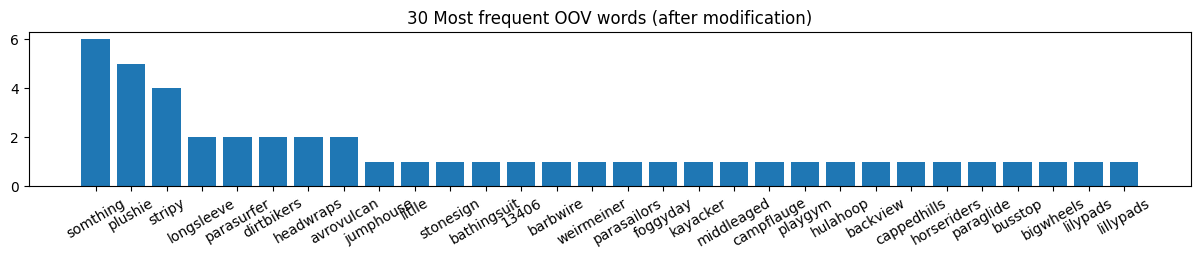


The captions contain in total 404513 words; with vocabulary size of 7759.

95 words, with total frequency of 112 are not included in GloVe
1.21% of captions vocabulary are not covered in GloVe.
0.03% (112) of total words are replaced with '<unk>'


In [8]:
def suffix_replace(word, pretrained_words_lst):
    """Replace the suffix of the word with the corresponding suffix in the pretrained_words_lst. 
    e.g. wakeboarder -> people with wakeboard, windsurfs -> windsurf
    if after modification, the words are included in pretrained embeddings, then return the modified words, otherwise return None"""
    suffix_mappings = {
        'er': lambda word: ("people with " + word[:-2] if word[:-2] in pretrained_words_lst 
                         else "people with " + word[:-1] if word[:-1] in pretrained_words_lst 
                         else None),
        'ers': lambda word: ("people with " + word[:-3] if word[:-3] in pretrained_words_lst 
                         else "people with " + word[:-2] if word[:-2] in pretrained_words_lst 
                         else None),
        'ing': lambda word: ("on " + word[:-3] if word[:-3] in pretrained_words_lst
                         else "on " + word[:-3]+'e' if word[:-3]+'e' in pretrained_words_lst
                         else None),
        'less': lambda word: ("without " + word[:-4] if word[:-4] in pretrained_words_lst 
                         else None),
        's': lambda word: (word[:-1] if word[:-1] in pretrained_words_lst 
                         else word[:-2] if word[:-2] in pretrained_words_lst 
                         else word[:-3]+'y' if word[:-3]+'y' in pretrained_words_lst
                         else None),
     }

    for suffix, func in suffix_mappings.items():
        if word.endswith(suffix):
            return func(word)
    return None


def correct_spelling(word, pretrained_words_lst):
    '''
    correct spelling errors
    if corrected word exists in GloVe mode, return the corrected word
    else return '<unk>'
    '''
    spell = SpellChecker()
    word_corrected = spell.correction(word) # correct the spelling
    if word_corrected in pretrained_words_lst:
        return word_corrected
    else: 
        return '<unk>'
    

def modify_caption(caption,pretrained_words_lst):
    '''
    For the words that are not found in glove model, apply spelling correction and convert it to american english.
    Replace with the corrected words in the caption if corrected words are included in glove model, otherwise replace with <unk> token.
    
    Output: modified caption
    '''
    global words_modification_dict, oov_lst
  
    caption = modify_str(caption)
    
    for word in caption.split():

        if word not in pretrained_words_lst: 

            # first check if word is already in the modification mappings
            if word in words_modification_dict.keys(): 
                caption = caption.replace(word, words_modification_dict[word])
                if words_modification_dict[word] == '<unk>':
                    oov_lst.append(word)
                
            # apply modification methods  
            else:
                word_mod = suffix_replace(word, pretrained_words_lst)
                if word_mod == None:
                    # spelling correction method
                    word_mod = correct_spelling(word,pretrained_words_lst)
                                
                caption = caption.replace(word, word_mod)
                words_modification_dict[word] = word_mod 
                if word_mod == '<unk>':
                    oov_lst.append(word)
    return caption


# apply the modification to whole captions file
words_modification_dict = {} # store the words before (key) and after (value) correction 
captions, oov_lst= [], []
for img_id, caption in captions_original[1:]:
    captions.append((img_id,modify_caption(caption, glove_word_lst)))


# display the out-of-vocabulary words after the captions' modification
oov_freq_after = Counter(oov_lst)
oov_freq_after = dict(sorted(oov_freq_after.items(), key=lambda item: item[1], reverse=True))
plot_frequent_words(oov_freq_after,0, 30, "30 Most frequent OOV words (after modification)")


# analyse the coverage of GloVe embeddings after the modification
words_freq_dict = extract_words_freq(captions)
print(f"{len(oov_freq_after)} words, with total frequency of {sum(oov_freq_after.values())} are not included in GloVe")
not_found_percentage = len(oov_freq_after)/(len(oov_freq_after) + len(words_freq_dict))
print(f"{not_found_percentage*100:.2f}% of captions vocabulary are not covered in GloVe.")
print(f"{sum(oov_freq_after.values())/sum(words_freq_dict.values())*100:.2f}% ({sum(oov_freq_after.values())}) of total words are replaced with '<unk>'")


-   The captions modification has effectively increased the GloVe coverage. 
-   While having only 1.21% of the words in my dataset not covered by GloVe is relatively low, I would use GloVe pretrained embeddings for my model. -  The total 112 not covered words are replaced with `<unk>` token.

## 2.3 Handle rare words 
-   A large size of vocabulary will enrich the semantic meaning of images. However, when the size is too large, it will increase the model complexity, memory usuage. So a good vocabulary should have a good balance between caption diversity (coverage) and model complexity.
-   My data contains a large amount of words which have only appeared once.  
-   I will analyse the frequency distribution and define the threshold for rare words.
-   replace the rare words with `<unk>` token. This will reduce the model complexity, memory usage, increase the generalization on unseen data. 

### Distribution of words frequency

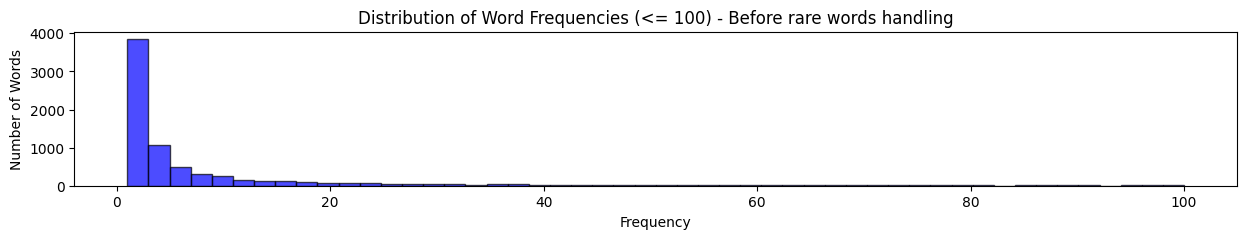

In [9]:
def plot_freq(freq_lst,title, n_bins = 50):
    plt.figure(figsize=(15, 2))
    plt.hist(freq_lst, bins=n_bins, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Distribution of Word Frequencies {title}')
    plt.xlabel('Frequency')
    plt.ylabel('Number of Words')
    plt.show()
    
freq_values = list(words_freq_dict.values())
freq_values_tail = [freq for freq in freq_values if freq <= 100]
freq_values_top = [freq for freq in freq_values if freq > 100]
plot_freq(freq_values_tail, "(<= 100) - Before rare words handling")

- Since the distribution of words frequency has a very long tail, meaning that a small number of high frequency words, large number of low frequency words. For better visual effect, only the words with frequencies under 100 are displayed. 
- There is a sharp peak at the very left side, indicating that there are many low frequency words. This is very common in natural language processing.

- Combining the information of caption size, vocabulary size, and upper frequency distribution, the words with frequency <= 5 are defined as rare words. They will be replaced with `<unk>`.


The captions contain in total 404513 words; with vocabulary size of 2846.

4913 words with frequency <= 5 are defined as rare. In total 8584 words are replaced with <unk>



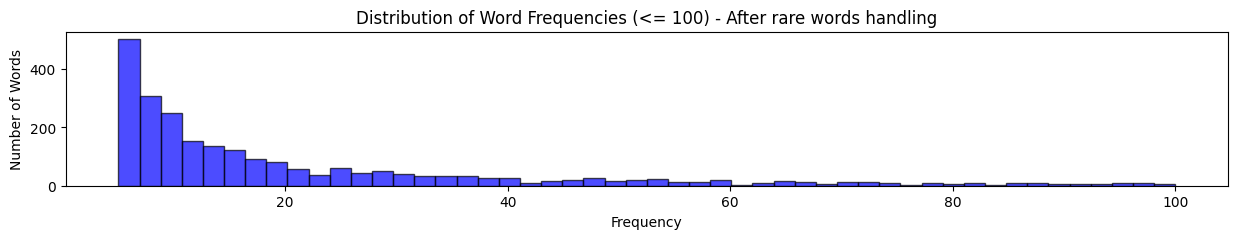

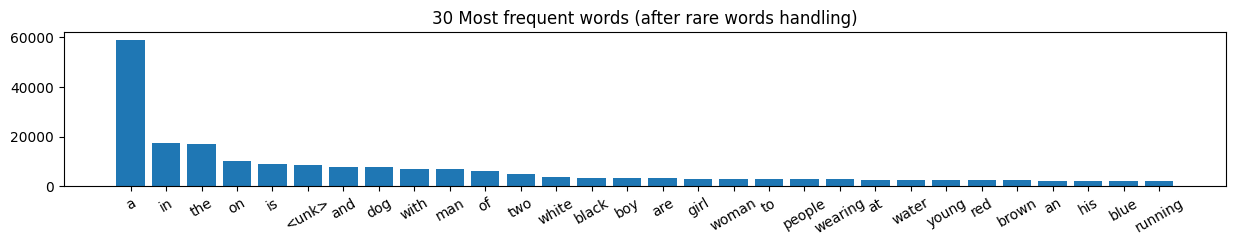

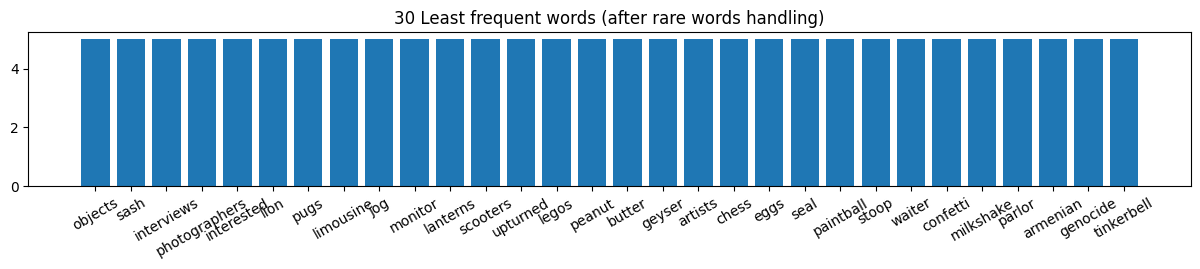

In [10]:
freq_thres = 5 
rare_words_lst = [key for key, value in words_freq_dict.items() if value < freq_thres]

# update captions: replace the rare words with '<unk>'
captions = [(img_id, ' '.join(['<unk>' if word in rare_words_lst else word for word in caption.split()]) )
    for img_id, caption in captions]

# extract words frequency of updated captions
words_freq_dict = extract_words_freq(captions) 
freq_unk = words_freq_dict['<unk>']
print(f'{len(rare_words_lst)} words with frequency <= {freq_thres} are defined as rare. In total {freq_unk} words are replaced with <unk>\n')

# plot 
freq_values = list(words_freq_dict.values())
freq_values_tail = [freq for freq in freq_values if freq <= 100]
freq_values_top = [freq for freq in freq_values if freq > 100]
plot_freq(freq_values_tail, "(<= 100) - After rare words handling")
plot_frequent_words(words_freq_dict,0, 30, "30 Most frequent words (after rare words handling)")
plot_frequent_words(words_freq_dict,-30, len(words_freq_dict), "30 Least frequent words (after rare words handling)")

-   In this step, 8584 words are replaced with `<unk>` token.
-   `<unk>` token becomes the 6th most frequent word.
-   valid vocabulary size is 2846.

## 2.4 Adjust caption lengths and add `<start>`,`<end>`,`<pad>` tokens
All captions must be adjusted to the same length because the tensor and model require consistency in input size.

First analyse the distribution of all caption lengths, analyse what would be a reasonal/optimal caption length. With too long caption length will increase computational complexity, and dilute the relevant information, increase overfitting risk. With too short caption length will lead loss of information and reduce the ability to capture complex scenes. 

In [11]:
caption_lengths = [len(caption.split()) for _, caption in captions]

caption_max = captions[np.argmax(caption_lengths)]
img_max = os.path.join(img_dir, caption_max[0])

caption_min = captions[np.argmin(caption_lengths)]
img_min = os.path.join(img_dir, caption_min[0])

print(f"Maximum caption {max(caption_lengths)}: {caption_max[1]}")
print(f"Minimum caption {min(caption_lengths)}: {caption_min[1]}")
print(f"Average caption length: {np.mean(caption_lengths).round(2)}, \nMedian caption length: {sorted(caption_lengths)[len(caption_lengths)//2]}")
print(f"Standard Deviation: {np.std(caption_lengths).round(2)}")

Maximum caption 33: a girl in a red and black leotard with white writing is standing next to a man in a cap and a girl in a hot pink and black and white checkered outfit
Minimum caption 1: a
Average caption length: 10.64, 
Median caption length: 10
Standard Deviation: 3.67


In [12]:
caption_length_threshold = 20
percentage = 100 * len([value for value in caption_lengths if value > caption_length_threshold]) / len(caption_lengths)
print(f"{percentage:.2f}% of captions need to be truncated.")

1.26% of captions need to be truncated.


- The length of captions are between 1 and 33.
- The longest caption describes very detailed dressing information. However, using such long captions require more complex model and more parameters, meaning higher risk of overfitting. It will also increase computational cost (longer training time and higher RAM usage) for training model. 

- The shortest caption contains only an 'a', which certainly can not contribute any semantic infortion of the image. They could even potentialy affect the learning process. For instance, with this caption, the model will learn to predict an `<end>` token with `a`. So I will replace the short captions (length 1 or 2) with the other suitable length captions of the same image to ensure consistency of input data shape.
  
- Finally, I set 20 as threshold length, around 1.26% of captions will be truncated.

### Adjust captions lengths and add 'start','end','pad' tokens
-   While adding 'start' and 'end' tokens to the captions, the maximum caption length will be 22
-   Long captions will be truncated
-   Add 'start' and 'end' tokens to all captions
-   Add 'pad' tokens to the captions that are shorter than the maximum caption length

In [13]:
# extract vocab, and place four tokens at the end
vocab = [key for key in words_freq_dict.keys() if key!= '<unk>'] + ['<unk>', '<start>','<end>','<pad>']

captions_final = [] 

for img_id in img_ids:
    
    # store all captions for each img_id in a nested list
    captions_lst = [caption.split() for id, caption in captions if id == img_id]

    # empty nested list to store adjusted captions
    captions_adj_lst, indices_lst = [], []
 
    # adjust caption length & add tokens (start, end, pad)
    for caption in captions_lst:
        
        # exclude the extreme short captions (containing only one or two words)
        if len(caption) > 2: 
            
            # truncate long captions
            if len(caption) >= caption_length_threshold:
                caption = caption[:caption_length_threshold] 
                
            # add start, end tokens for all captions
            caption_adj = ['<start>'] + caption + ['<end>']
            
            # add pad tokens for the short captions till fixed length 
            while len(caption_adj) < (caption_length_threshold + 2):
                caption_adj.append('<pad>')
            
            captions_adj_lst.append(caption_adj)
            indices_lst.append([vocab.index(word) for word in caption_adj])
        
    # make sure every image has 5 groups of captions, otherwise use duplicates of existing captions 
    while len(captions_adj_lst) < 5:
        n = 0
        captions_adj_lst.append(captions_adj_lst[n])
        n += 1
        
    while len(indices_lst) < 5:
        n = 0
        indices_lst.append(indices_lst[n])
        n += 1
        
    captions_final.append((img_id,captions_adj_lst,indices_lst)) # captions_final: nested list [img_id, [[caption 1],[..2],[..3], [..4], [caption 5]],[[indices 1],[..2],[..3],[..4],[indices 5]]]

### Check if the semantic infomation of captions are still remained after all the preprocessing

In [14]:
# randomly select 5 images and display their captions 
random.seed(120)
for idx in [random.randint(1, len(captions_final)) for _ in range(5)] :
    captions_ = captions_final[idx][1]
    print(f"\nimage {captions_final[idx][0]}:\n")
    for caption_ in captions_:
        print(caption_)


image 2701895972_8605c4e038.jpg:

['<start>', 'a', 'band', 'is', 'playing', 'music', 'underneath', 'a', 'white', 'canopy', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'band', 'performs', 'at', 'on', 'an', 'outdoor', 'stage', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'band', 'performs', 'onstage', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'band', 'performs', 'at', 'outdoor', 'event', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'people', 'gather', 'to', '<unk>', 'musicians', 'play', 'various', 'instruments', 'upon', 'a', 'stage', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

-   The major semantic informations are not lost.
-   In the randomly displayed 25 captions, in total 9 `<unk>` tokens are found. Captions are still in a reasonable sentence structure and with good descriptions. This suggests, the rare words handling does not significantly affect much the captions' quality. 

## 2.5 Create embedding matrix for my vocabulary

-   Extract the vectors for my vocabulary from the pretrained embeddings. 
-   Special tokens `<start>`, `<end>`, `<pad>`, `<unk>` are not included in pretrained embeddings. It is recommended to use 
    -   average of vocabulary embeddings to represent `<unk>`, 
    -   zero vector to represent `<pad>`, as this will minimizes their influence and make them easily identifiable.
    -   random vectors for `<start>`, `<end>`.

In [15]:
def create_vocab_embeddings(embeddings_dict):
    
    embedding_dim = len(embeddings_dict['the']) 
    
    # to store vectors for the words in vocab
    vocab_embeddings = torch.zeros(len(vocab), embedding_dim)
    
    for i, word in enumerate(vocab[:-4]):
        vocab_embeddings[i] = torch.tensor(embeddings_dict[word])

    # use average vector as '<unk>'  
    vocab_embeddings[vocab.index('<unk>')] = vocab_embeddings.mean(dim=0).unsqueeze(0)
    # use normal distribution for '<start>' and '<end>' tokens
    mean = vocab_embeddings.mean()
    std = vocab_embeddings.std()
    vocab_embeddings[vocab.index('<start>')] = torch.normal(mean=mean, std=std, size=(embedding_dim,))
    vocab_embeddings[vocab.index('<end>')] = torch.normal(mean=mean, std=std, size=(embedding_dim,))
    # vector for '<pad>' stays as zero 
    return vocab_embeddings.to(dtype=torch.float32)


vocab_emb_100 = create_vocab_embeddings(glove_100)
vocab_emb_200 = create_vocab_embeddings(glove_200)
vocab_emb_100.shape, vocab_emb_200.shape, len(vocab)

(torch.Size([2849, 100]), torch.Size([2849, 200]), 2849)

# 3 Split data

- split the dataset to train, validation, and testset by ratio of 8:1:1
- image transformation
    - Resize all images to 224x224x3, because it is a size with good balance between sufficient details and computational efficiency. Many pretrained CNN models, like ResNet are trained on images with this size. Using this size ensures the network could extract meaningful features effectively.
    - Normalize image pixel values for each channel by mean and standard deviation of all images

In [16]:
# customise dataset
def customdataset(img_ids_lst):
    '''
    return a result containing two tensors:
    - image_tensors: index instead of the whole image data
    - indices_tensors: corresponding caption indices
    -----------------
    img_dir: the directory of all images
    img_ids_lst: a list to store image IDs, e.g. a list to store all trainset image IDs
    captions: the adjusted captions file, it has the same structure as the original captions file. 
    '''
    image_tensors, indices_tensors, words_tensors = [], [], []
    for img_id in img_ids_lst:

        indices = torch.tensor([indices_ for id_, _, indices_ in captions_final if id_ == img_id][0])

        indices_tensors.append(indices)

    image_tensors = torch.tensor(list(range(len(img_ids_lst))))  
    indices_tensors = torch.stack(indices_tensors, dim=0) 
     
    return TensorDataset(image_tensors, indices_tensors)


def transform_info(img_size):
    """
    get transform information (resize, totensor, normalization) for images
        """
    # calculate the mean and standard deviation of all images 
    mean_sum = np.zeros((3))
    std_sum = np.zeros((3))

    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()])
    
    for img_id in img_ids:
        image_path = os.path.join(img_dir, img_id)
        image = Image.open(image_path) # shape [3, x_pixels, y_pixels]
        image = transform(image)
        mean_sum += torch.mean(image, dim=(1, 2)).numpy()
        std_sum += torch.std(image, axis=(1,2)).numpy()
    
    mean_ch = (mean_sum / len(img_ids)).tolist()
    std_ch = (std_sum / len(img_ids)).tolist()
    print(f"Mean: {mean_ch}, Standard deviation: {std_ch}")
    
    # scale and normalize images
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean_ch, std = std_ch),
    ])
    return transform, mean_ch, std_ch
    

def customdataset(img_dir, img_ids_lst, img_captions, vocab, transform):
    image_tensors, indices_tensors, words_tensors = [], [], []
    for img_id in img_ids_lst:
        
        image_path = os.path.join(img_dir, img_id)
        image = Image.open(image_path)
        if transform:
            image = transform(image)
        # index of the image name in img_captions
        idx = [i for i, img in enumerate(img_captions) if img[0] == img_id][0]

        indices = torch.tensor(img_captions[idx][2])
        image_tensors.append((image))
        indices_tensors.append((indices))

    image_tensors = torch.stack(image_tensors, dim=0)   
    indices_tensors = torch.stack(indices_tensors, dim=0)
    return TensorDataset(image_tensors, indices_tensors)



In [17]:
random.seed(2)
random.shuffle(img_ids)

train_ratio = 0.8  # 80% for training
valid_ratio = 0.1  # 10% for validation
test_ratio = 0.1  # 10% for testing

# determine the number of image_id for each set
count_imgs = len(img_ids)
num_train = int(train_ratio * count_imgs)
num_valid = int(valid_ratio * count_imgs)
num_test = count_imgs - num_train - num_valid

# split the image_ids into three sets
train_img_ids = img_ids[:num_train]
valid_img_ids = img_ids[num_train:(num_train + num_valid)]
test_img_ids = img_ids[(num_train + num_valid):]

# create datasets
transform, mean_ch, std_ch = transform_info(224)
trainset = customdataset(img_dir, train_img_ids, captions_final, vocab, transform)
validset = customdataset(img_dir, valid_img_ids, captions_final, vocab, transform)
testset = customdataset(img_dir, test_img_ids, captions_final, vocab, transform)


trainset_small = Subset(trainset, list(range(4)))
validset_small = Subset(validset, list(range(4)))
testset_small = Subset(testset, list(range(4)))

print(f"Trainset datasize: {len(trainset)}, Validset datasize: {len(validset)}, Testset datasize: {len(testset)}")
print(f"Trainset image shape: {trainset[0][0].shape}, indices shape: {trainset[0][1].shape}")

Mean: [0.45803604669974385, 0.446106527687388, 0.4039241149212358], Standard deviation: [0.2307407706170195, 0.22168387993369051, 0.2259262763143337]
Trainset datasize: 6472, Validset datasize: 809, Testset datasize: 810
Trainset image shape: torch.Size([3, 224, 224]), indices shape: torch.Size([5, 22])


### Check if dataset is correctly generated.

Randomly check one example in each dataset. Convert the indices to words, and comparing them with its original captions.

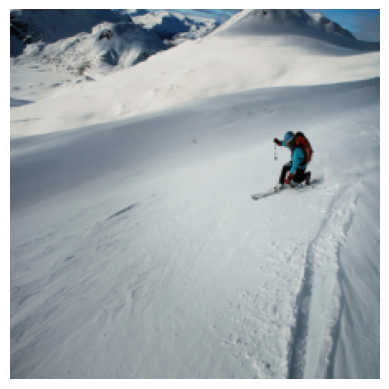

The caption tokens are converted correctly!
[['<start>', 'a', 'lone', 'skier', 'skiing', 'down', 'a', 'snowy', 'mountain', 'on', 'one', 'ski', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<start>', 'a', 'man', 'skis', 'downhill', 'on', 'a', 'mountain', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<start>', 'a', 'mountain', 'skier', 'heads', 'down', 'a', 'mountain', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<start>', 'a', 'skier', 'in', 'a', 'blue', 'outfit', 'is', 'skiing', 'down', 'the', 'hill', 'with', 'a', 'red', 'pack', 'on', 'his', 'back', '<end>', '<pad>', '<pad>'], ['<start>', 'a', 'snowboarder', 'on', 'a', 'wide', 'plain', 'of', 'snow', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
[['<start>

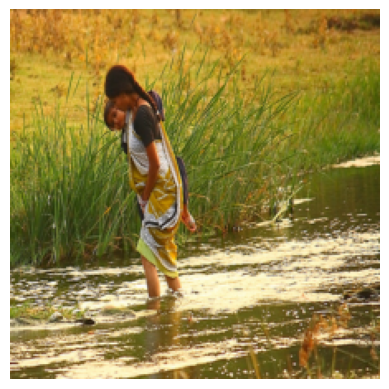

The caption tokens are converted correctly!
[['<start>', 'a', 'woman', 'holding', 'a', 'child', 'is', 'walking', 'through', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<start>', 'a', 'woman', 'in', 'yellow', 'carries', 'a', 'child', 'in', 'the', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<start>', 'a', 'woman', 'is', 'carrying', 'a', 'child', 'through', 'a', 'small', 'river', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<start>', 'a', 'woman', 'is', 'carrying', 'her', 'child', 'while', '<unk>', 'through', 'shallow', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<start>', 'lady', 'carrying', 'her', 'child', 'in', 'the', 'river', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

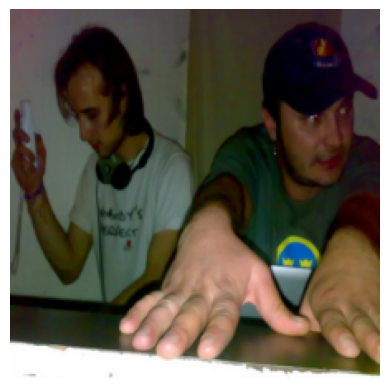

The caption tokens are converted correctly!
[['<start>', 'a', 'man', 'in', 'a', 'green', 'shirt', 'and', 'cap', 'puts', 'his', 'hands', 'on', 'a', 'table', 'as', 'he', 'stands', 'next', 'to', 'man', '<end>'], ['<start>', 'a', 'man', 'wearing', 'a', 'white', 'shirt', 'is', 'sitting', 'next', 'to', 'a', 'man', 'wearing', 'a', 'green', 'shirt', '<end>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<start>', 'one', 'man', 'has', 'his', 'hands', 'outstretched', 'while', 'another', 'has', 'headphones', 'around', 'his', 'neck', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<start>', 'there', 'is', 'a', 'guy', 'with', 'headphones', 'around', 'his', 'neck', 'next', 'to', 'a', 'guy', 'in', 'a', 'hat', 'looking', 'off', 'screen', '<end>', '<pad>'], ['<start>', 'a', 'man', 'in', 'a', 'green', 'shirt', 'and', 'cap', 'puts', 'his', 'hands', 'on', 'a', 'table', 'as', 'he', 'stands', 'next', 'to', 'man', '<end>']]
[['<start>', 'a', 'man', 'in', 'a', 'green', 'shirt', 'and', 'cap

In [18]:
# check if the caption tokens are converted correctly in the dataset
img_ids_lst = [train_img_ids, valid_img_ids, test_img_ids]
for i,dataset in enumerate([trainset, validset, testset]):
    idx_lst = [random.randint(0, len(dataset)) for _ in range(1)] 
    dataset_img_ids = img_ids_lst[i]
    for idx in idx_lst:
        # display the image
        img = dataset[idx][0].permute(1, 2, 0)* torch.tensor(std_ch) + torch.tensor(mean_ch)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        word_indices = dataset[idx][1]  
        converted_captions = [[vocab[index] for index in caption] for caption in word_indices]
        # search the img_id in captions file and return the captions 
        reference_captions = [captions for img_id,captions,indices in captions_final if img_id == dataset_img_ids[idx]][0]
        if converted_captions == reference_captions:
            print("The caption tokens are converted correctly!")   
        print(converted_captions)
        print(reference_captions)

All three groups of captions are correctly converted. All images match to their corresponding captions. This tells, the datasets are managed correctly.

# 4 Model V1: CNN-LSTM with pretrained GloVe embeddings

I will use the architecture described in the paper show and tell for image captioning, a pretrained CNN model as encoder and LSTM as decoder, with integration of pretrained GloVe embeddings.

**EncoderCNN:**
- CNN will extract features from input image, and transform the output to vectors with the length of embedding dimension. 
- I will use pre-trained CNN models instead of training from scratch, as this will save training time and RAM usage, and yield a good performance even with small input data size. As my RAM is very limited, I will test two pretrained models, ResNet50 and SqueezeNet1_0, to find out a good balance between computational cost and performance,
    -   ResNet50 is often preferred for tasks like image captioning. It has 50 layers (25M parameters), which is deep enough to capture simple and complex features. Though its computational cost is much intensive than deeper networks like ResNet-101, it may still occupy too much RAM. 
    -   SqueezeNet1_0 is specifically designed to be a compact and effective model. It has 10 primary convolutional layers (1.2M parameters), which is quite shallow compared ResNet or VGG families. It offers a good balance between compuational cost and performance.

**DecoderRNN:**
- LSTM is preferred for sequences modeling, as it is able to remember the long-term dependencies.
- It contains a LSTM layer with dropout which will randomly drop part of the parameters in hidden layer to enhance the model generalization. Layer normalization is applied right after the LSTM outputs and before the fully connected layer, which means each batch's output from the LSTM gets normalized before processed to fully connected layer. It prevent large swings in input which may cause exploding or vanishing gradients. 

- For the training process, teacher forcing will be applied. LSTM will take the CNN output feature and the reference caption embeddings as inputs to generate captions of the next step.  This helps LSTM to learn more effectively. 
- For the evaluation process, iterate over the maximum sequence length (here 22), LSTM will take the CNN output feature (for the first word prediction), the predicted caption from last step and the states as input. 


**train and evaluation process:** 
- Weights & Biases is used to initialize a new run and log the configuration settings (hyperparameters) for the model.
- Data loaders: include the choices of using small dataset for quick testing model's learning efficiency and full dataset.
- Training: 
    -   **Reference captions selection**
        -   For overfitting test, only the first reference caption will be used for training.
        -   For the full dataset, different strategies have been applied, they are marked at the runs.
            -   some runs (old) took the first reference caption for training
            -   some runs randomly selected one of the five reference captions for training
            -   some runs selected a group of five reference captions one after another for training, this means, take first captions for epoch 0, take the second captions for epoch 1....
    -   **Image augmentation** is applied to trainset images to increase the data diversity, enhance generalization. 

- **Loss**: use cross entropy to calculate loss between probability vectors of reference and predicted captions. 
    - Train set: loss is calculated between the predicted caption and the corresponding input reference caption for each image.
    - Validation set: since there is no reference caption as input, loss is caluclated between 5 reference captions and 1 predicted caption, for each image, I use the smallest value to represent its loss.
      
- **BLEU (Bilingual Evaluation Understudy) Scores**: It is a metric to evaluate the quality of machine-generated text. It compares the predicted caption to one or multiple true captions. I will use BLEU1, BLEU2, BLEU3 and BLEU4 to evaluate model performance. For each image, the BLEUs are calculatd between one predicted caption and five reference captions. The start, end, pad tokens are excluded for BLEU calculation to ensure the evaluations focus on the semantic quality of generated captions.
    - BLEU1 focuses on the overlap of individual words (unigrams) between the generated caption and the reference captions. It measures the proportion of words in the generated caption that also appear in the reference captions. It does not consider word order or grammatical structure.   
    - BLEU2,3,4 consider the overlap between the generated and reference captions up to 4-grams. This means, they considers the correct order and grammatical structure to some extent.

- **learning rate decay**: is helpful to improve model convergence. In the early stages of training, larger learning rate is useful for making rapid progress. When the model begins to converge, lower learning rate is better for fine-tuning the model's parameters.
    - learning rate is multiplied by a certain rate (usually use rate between 0.9 - 1) over each epoch
    - learning rate is multiplied by 0.5 when the training loss is not decreased over a certain epochs

- **save the optimal model**:
    -  save models every 3 epochs
    -  small dataset: with the highest train BLEU1
    -  large dataset: with the highest validation BLEU1
- **early stop**:
    -  when the validation BLEU1 is not increased over a certain epochs, training process will be stopped. 


In [19]:
start_idx = vocab.index('<start>')
end_idx = vocab.index('<end>')
pad_idx = vocab.index('<pad>')
max_len = caption_length_threshold + 2

# image augmentation
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(degrees=15)   # random rotation within 15 degrees
])

In [20]:
# CNN-LSTM model architecture

# with pretrained ResNet50 model & pretrained GloVe embeddings
class EncoderCNN(nn.Module):
    def __init__(self, embed_dim):
        super(EncoderCNN, self).__init__()
        self.embed_dim = embed_dim
        
        # Load a pre-trained CNN model ResNet-50 without the final classification layer (fc)
        self.resnet_full = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet_full.children())[:-1]) 
        
        # freeze the parameters in ResNet
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(self.resnet_full.fc.in_features, self.embed_dim) # embed size means the size of the output vector


    def forward(self, images):
        features = self.resnet(images) # shape: (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1) # shape: (batch_size, 2048)
        features = self.fc(features) # shape: (batch_size, embed_dim)
 
        return features  

class DecoderRNN(nn.Module):
    def __init__(self, embed_dim, hidden_size, vocab_size, max_len, dropout_rate, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed_dim = embed_dim
        self.max_len = max_len  # maximum sequence length
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_size) 
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions = None):
        
        # for training set: teacher forcing
        if captions is not None:
            batch_output_tensor = []
            
            # embed the caption indices with vectors
            if self.embed_dim == 100:
                embeddings = vocab_emb_100[captions] # shape( batch_size, max_len, 100)
            elif self.embed_dim == 200:
                embeddings = vocab_emb_200[captions] # shape( batch_size, max_len, 200)

            # add the features extracted from CNN, drop the last embedded word (either end or pad) because further prediction is not needed.
            embeddings = torch.cat((features.unsqueeze(1), embeddings[:,:-1,:]), dim=1) # shape( batch_size, max_len, embed_dim)
            lstm_out, _ = self.lstm(embeddings) # lstm_out shape: (batch_size, max_len, hidden_size)
            lstm_out = self.layer_norm(lstm_out)
            
            batch_output_tensor = self.fc(lstm_out)# probability output shape: (batch_size, max_len, vocab_size)
        
        # for validation set
        if captions is None:
            input_tensor = features.unsqueeze(1) # first input (batch_size, 1, 100)
            output_lst = []  # to concate all outputs (intotal max_len outputs)
            all_output_indices = [] 
            states = None  # store LSTM states
            
            for i in range(self.max_len):
                lstm_out, states = self.lstm(input_tensor, states)
                lstm_out = self.layer_norm(lstm_out)
                output_tensor = self.fc(lstm_out) # (batch_size, 1, vocab_size)
                output_lst.append(output_tensor)

                # convert output probabilities to indices further to embedding vectors, and use them as input for predicting the next word
                output_indices = torch.argmax(output_tensor, dim=2) # (batch_size, 1)
                all_output_indices.append(output_indices)
                if self.embed_dim == 100:
                    input_tensor = vocab_emb_100[output_indices] # (batch_size, 1, 100) 
                if self.embed_dim == 200:
                    input_tensor = vocab_emb_200[output_indices] # (batch_size, 1, 200) 
  
            batch_output_tensor = torch.cat(output_lst, dim=1)  # (batch_size, max_len, vocab_size)
  
        return batch_output_tensor


class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_dim, hidden_size, vocab_size, max_len, dropout_rate, num_layers):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_dim)
        self.decoder = DecoderRNN(embed_dim, hidden_size, vocab_size, max_len, dropout_rate, num_layers)

    def forward(self, images, captions=None):
        features = self.encoder(images)
        if captions != None:
            outputs = self.decoder(features,captions)
        if captions == None:
            outputs = self.decoder(features)
        return outputs


In [38]:
# V1: updated with random caption selection and image augmentation
def train_eval(config):
    with wandb.init(project='dl_mc2', entity='weiping-zhang', config=config) as run:
        config = run.config
        config.checkpoint_dir = wandb.run.dir
        embed_dim = config['embed_dim'] 
        num_layers = config['num_layers']
        hidden_size = config['hidden_size']
        data_type = config['data_type'] 
        dropout_rate = config['dropout_rate']
        lr_decay_rate = config['lr_decay_rate']
        vocab_size = len(vocab) 
        best_train_loss = float('inf')
        best_valid_bleu1 = 0
        learning_rate = config['learning_rate']
        batch_size = config['batch_size']
        early_stop_epochs = config['early_stop_epochs']
        save_model = config['save_model']
        model_name = f"{learning_rate}_{batch_size}_{hidden_size}_{embed_dim}_{data_type}_{config['model']}_{save_model}"  # trained model will be saved with this name
        
        early_stop_counter, early_stop_counter, update_lr_counter, best_train_bleu1 = 0, 0, 0, 0
    
        # load data
        if data_type == 'small':
            train_loader = DataLoader(trainset_small, batch_size=batch_size, shuffle=True, num_workers=2)
            valid_loader = DataLoader(validset_small, batch_size=batch_size, shuffle=False, num_workers=2)
        elif data_type == 'large': 
            train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
            valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)
            
        # model
        if config['model'] == 'cnn_rnn':
            model = ImageCaptioningModel(embed_dim, hidden_size, vocab_size, max_len, dropout_rate, num_layers)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # define the loss with reduction='sum', meaning that the loss is the sum of the batch losses
        criterion = nn.CrossEntropyLoss(reduction='sum')

        for epoch in range(config['epochs']):
            ################ train process ################
            model.train()
            for param in model.parameters():
                param.requires_grad = True
            sum_epoch_loss, sum_epoch_bleu1, sum_epoch_bleu2, sum_epoch_bleu3, sum_epoch_bleu4, count_train = 0.0, 0.0, 0.0, 0.0, 0.0, 0


            # determine how many captions per image to use
            if config['num_caption'] ==1: # for overfitting test: use the first caption for all images in the batch
                idx_cap = 0
            else:
                idx_cap = epoch%config['num_caption'] # for each epoch, use a different caption for all images in the batch
                # idx_cap = random.randint(0, config['num_caption']) # randomly select a caption group for all images in the batch
            
            for n,batch in enumerate(train_loader):
               
                images, caption_indices_5 = batch # images shape: (batch_size,3,224,224), caption_indices shape: (batch_size, 5, max_len)
                                               
                num_img = images.shape[0]
                count_train += num_img

                images = augmentation(images)   
                caption_indices = caption_indices_5[:,idx_cap,:]  # the i-th of the total 5 captions for each batch, shape (batch_size, max_len)

                # True probabilities: each true index is represented with a vector, with 1 at the true index and rest are 0.
                true_prob = torch.zeros(caption_indices.shape[0], caption_indices.shape[1], len(vocab)) # (batch_size, max_len, vocab_size)
                true_prob = true_prob.scatter_(2, caption_indices.unsqueeze(2), 1) # (batch_size, max_len, vocab_size)
                
                # forward pass
                optimizer.zero_grad()
                pred_prob = model(images, caption_indices) # predicted probabilities shape (batch_size, max_len, vocab_size)

                # loss: between predicted caption and reference caption
                loss = criterion(pred_prob, true_prob)/num_img  # average loss per image, as the last batch may have less images
                loss.backward()
                optimizer.step()

                # add up the batch loss () to epoch loss 
                sum_epoch_loss += loss*num_img

                # BLEU calculation: predicted caption and 5 reference captions
                true_indices_lst = caption_indices_5.detach().numpy().tolist() # (batch_size, 5, max_len)
                pred_indices_lst = torch.argmax(pred_prob, dim=2).numpy().tolist() # (batch_size, max_len)
   
                # iterate over each image in the batch
                for i in range(len(true_indices_lst)): 
                
                    # keep only the captions between start and end tokens, exclude start, end, pad tokens
                    true_indices_i = [extract_before_end(caption) for caption in true_indices_lst[i]] # nested list shape (5, < max_len)
                    pred_indices_i = extract_before_end(pred_indices_lst[i]) # list shape with length < max_len
                    
                    bleu_score1 = sentence_bleu(true_indices_i, pred_indices_i, weights=(1, 0, 0, 0))
                    bleu_score2 = sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 1, 0, 0))
                    bleu_score3 = sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 0, 1, 0))
                    bleu_score4 = sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 0, 0, 1))
         
                    # add up the BLEU scores (per image) to the epoch BLEU
                    sum_epoch_bleu1 += bleu_score1
                    sum_epoch_bleu2 += bleu_score2
                    sum_epoch_bleu3 += bleu_score3
                    sum_epoch_bleu4 += bleu_score4
                    

            wandb.log({'Train Loss': sum_epoch_loss / count_train, 'Train BLEU1': sum_epoch_bleu1 / count_train, 'Train BLEU2': sum_epoch_bleu2 / count_train, 'Train BLEU3': sum_epoch_bleu3 / count_train, 'Train BLEU4': sum_epoch_bleu4 / count_train, 'lr': optimizer.param_groups[0]['lr']},step=epoch)


           # save the model every 3 epochs and the best model
            if epoch % 3 == 0:
                torch.save(model.state_dict(), f'model_{model_name}_{epoch}.pth')

           # for small set based on train bleu1
            epoch_train_bleu1 = sum_epoch_bleu1 / count_train
            if data_type == 'small' and epoch_train_bleu1 > best_train_bleu1:
                torch.save(model.state_dict(), f'best_train_bleu1_model_{model_name}.pth')

            # early stopping
            if data_type == 'small' and sum_epoch_bleu4 / count_train == 1:
                print(f"Early stopping because BLEU4 is 1")
                break

            # update learning rate 
            #average_epoch_loss = sum_epoch_loss / count_train
            if epoch_train_bleu1 > best_train_bleu1: 
                best_train_bleu1 = epoch_train_bleu1
                update_lr_counter = 0     
            else:
                update_lr_counter += 1  
            # 1. update learning rate by 0.5
            if update_lr_counter >= config['update_lr_epochs']:
                learning_rate *= 0.5
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                update_lr_counter = 0
            # 2. update learning rate by lr_decay_rate (usually between 0.9 - 1)
            else:
                learning_rate *= lr_decay_rate
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                
            
            ################ evaluation process ################
            model.eval()
            sum_epoch_loss, sum_epoch_bleu1, sum_epoch_bleu2, sum_epoch_bleu3, sum_epoch_bleu4, count_valid = 0.0, 0.0, 0.0, 0.0, 0.0, 0
            with torch.no_grad():
                for batch in valid_loader:
                    images, caption_indices = batch # images shape: (batch_size,3,224,224), caption_indices shape: (batch_size, 5, max_len)
                    num_img = images.shape[0]
                    count_valid += num_img

                    true_prob = torch.zeros(caption_indices.shape[0], caption_indices.shape[1], caption_indices.shape[2], len(vocab)) # (batch_size, 5, max_len, vocab_size)
                    true_prob = true_prob.scatter_(3, caption_indices.unsqueeze(3), 1) # (batch_size, 5, max_len, vocab_size)
                
                    pred_prob = model(images)  # predicted probabilities (batch_size, max_len, vocab_size)
                 
                    # BLEU calculation
                    true_indices_lst = caption_indices.detach().numpy().tolist() # (batch_size, 5, max_len)
                    pred_indices = torch.argmax(pred_prob, dim=2).detach().numpy().tolist() # (batch_size, max_len)
                    
                    ## iterate over each image in the batch
                    for i in range(len(true_indices_lst)): 
                        # keep only the captions between start and end tokens, exclude start, end, pad tokens
                        true_indices_i = [extract_before_end(caption) for caption in true_indices_lst[i]] # 5 reference captions: nested list shape (5, < max_len)
                        pred_indices_i = extract_before_end(pred_indices[i]) # 1 predicted caption: list with length < max_len
                      
                        bleu_score1 = (sentence_bleu(true_indices_i, pred_indices_i, weights=(1, 0, 0, 0)))
                        bleu_score2 = (sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 1, 0, 0)))
                        bleu_score3 = (sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 0, 1, 0)))
                        bleu_score4 = (sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 0, 0, 1)))
        
                        # add the BLEU scores per image to the epoch BLEUs
                        sum_epoch_bleu1 += bleu_score1
                        sum_epoch_bleu2 += bleu_score2
                        sum_epoch_bleu3 += bleu_score3
                        sum_epoch_bleu4 += bleu_score4
    
                        # loss for validation set
                        # for each image, take the smallest loss of the five losses (calculated with 5 reference captions)
                        loss_5_lst = []
                        for j in range(5): #  iterate over 5 reference captions
                            loss = criterion(pred_prob[i,:,:], true_prob[i,j,:,:])
                            loss_5_lst.append(loss)
                        sum_epoch_loss += np.min(loss_5_lst)
        
                epoch_valid_bleu1 = sum_epoch_bleu1 / count_valid
                wandb.log({'Valid Loss': sum_epoch_loss / count_valid, 'Valid BLEU1': sum_epoch_bleu1 / count_valid, 'Valid BLEU2': sum_epoch_bleu2 / count_valid, 'Valid BLEU3': sum_epoch_bleu3 / count_valid, 'Valid BLEU4': sum_epoch_bleu4 / count_valid},step=epoch)
    
                
                # check early stopping for large dataset (only when the model is not underfitting), it is based on valid BLEU1
                
                if data_type == 'large'  and epoch_valid_bleu1 < epoch_train_bleu1:
                    if epoch_valid_bleu1 > best_valid_bleu1:
                        best_valid_bleu1 = epoch_valid_bleu1
                        early_stop_counter = 0
                        
                        # save the best model based on valid BLEU1
                        torch.save(model.state_dict(), f'best_valid_bleu1_model_{model_name}.pth')
                        
                    elif epoch_valid_bleu1 <= best_valid_bleu1: 
                        early_stop_counter += 1
                        
                    if early_stop_counter >= early_stop_epochs: 
                        print('Early stop!')
                        break



def extract_before_end(caption):
    """
    Extract words from a caption, till the first occurrence of end_idx, exclude start, pad, end tokens.
    """
    indices = []
    for idx in caption:
        if idx == end_idx or idx ==pad_idx:
            break 
        if idx != start_idx:
            indices.append(idx)
    return indices

def display_wandb(config):
    """integrating wandb plots in notebook"""
    sweep_id = wandb.sweep(config, project='dl_mc2')
    sweep_url = f"https://wandb.ai/weiping-zhang/dl_mc2/sweeps/{sweep_id}"
    display(IFrame(sweep_url, width="100%", height=500))
    wandb.agent(sweep_id, function=lambda: train_eval(config))



`evaluation` function will evaluate a trained model performance on train, validation or testset.
The output includes the results with highest BLUE4, BLEU3, BLEU2, BLEU1 and with worst BLEU1 to understand the quality of generated captions by the model.

In [69]:
def evaluation(model, trained_model, loader, img_ids_lst, data_type, plot_max_min = True, eval_trainset = False):
    model.load_state_dict(torch.load(trained_model))
    model.eval()
    image_lst, pred_lst, true_lst, bleu1_lst, bleu2_lst, bleu3_lst, bleu4_lst = [], [], [], [], [], [], [] 
   
    for batch in loader: 
        images, caption_indices = batch # images shape: (batch_size,3,224,224), caption_indices shape: (batch_size, 5, max_len)

        # training set
        if eval_trainset == True: 
            pred_prob = model(images, caption_indices[:,0,:]) # use first predicted caption for each image as input, pred_prob shape (batch_size, max_len, vocab_size)
        
        # validation set and test set
        else: 
            pred_prob = model(images) 

        # convert reference captions to words (5 per image)
        true_captions_lst = caption_indices.detach().numpy().tolist() # shape (batch_size, 5, max_len) 

        # use captions without <start>, <end>, and <pad> tokens for BLEU calculation
        true_captions_no_tokens_lst = [[[vocab[idx] for idx in extract_before_end(caption)] for caption in batch] for batch in true_captions_lst]
        # use full captions for print out
        true_captions_with_tokens_lst = [[[vocab[idx] for idx in caption] for caption in batch] for batch in true_captions_lst]

        # convert predicted captions to words
        pred_indices = torch.argmax(pred_prob, dim=2) # shape: (batch_size, max_len)
        pred_captions_no_tokens_lst = [[vocab[idx] for idx in extract_before_end(caption)] for caption in pred_indices]
        pred_captions_with_tokens_lst = [[vocab[idx] for idx in caption] for caption in pred_indices]

        for i in range(len(true_captions_lst)): # iterate over images in the batch
            true_captions = [caption for caption in true_captions_no_tokens_lst[i]] # (5, < max_len)
            bleu_score1 = sentence_bleu(true_captions, pred_captions_no_tokens_lst[i], weights=(1, 0, 0, 0))
            bleu_score2 = sentence_bleu(true_captions, pred_captions_no_tokens_lst[i], weights=(0, 1, 0, 0))
            bleu_score3 = sentence_bleu(true_captions, pred_captions_no_tokens_lst[i], weights=(0, 0, 1, 0))
            bleu_score4 = sentence_bleu(true_captions, pred_captions_no_tokens_lst[i], weights=(0, 0, 0, 1))
            bleu1_lst.append(bleu_score1)
            bleu2_lst.append(bleu_score2)
            bleu3_lst.append(bleu_score3)
            bleu4_lst.append(bleu_score4)
            image_lst.append(images[i])
            pred_lst.append(pred_captions_with_tokens_lst[i])
            true_lst.append(true_captions_with_tokens_lst[i])
                
    print(f"average BLEU1 of the whole dataset: {np.mean(bleu1_lst):.5f}")
    print(f"average BLEU2 of the whole dataset: {np.mean(bleu2_lst):.5f}")
    print(f"average BLEU3 of the whole dataset: {np.mean(bleu3_lst):.5f}")
    print(f"average BLEU4 of the whole dataset: {np.mean(bleu4_lst):.5f}")

    if plot_max_min and data_type == 'small':
        for i in range(len(bleu1_lst)):
            print(f"BLEU4 {(bleu4_lst[i]):.5f}, BLEU3 {(bleu3_lst[i]):.5f}, BLEU2 {(bleu2_lst[i]):.5f}, BLEU1 {(bleu1_lst[i]):.5f}): \n\npredicted caption: \n{pred_lst[i]} \n\nreference captions: ")
            
            plot_pred_img_captions(i, true_lst,image_lst, std_ch, mean_ch)



    if plot_max_min and data_type == 'large':
        # image with largest BLEU4, BLEU3, BLEU2, BLEU1
        max_bleu4_idx = np.argmax(bleu4_lst) 
        max_bleu3_idx = [idx for idx in top_indices(bleu3_lst,2) if idx != max_bleu4_idx][0]
        max_bleu2_idx = [idx for idx in top_indices(bleu2_lst,3) if idx != max_bleu4_idx and idx != max_bleu3_idx][0]
        max_bleu1_idx = [idx for idx in top_indices(bleu1_lst,4) if idx != max_bleu4_idx and idx != max_bleu3_idx and idx != max_bleu2_idx][0]
        
        if bleu4_lst[max_bleu4_idx] > 0.05:
            print("--------------------\n")
            print(f"best BLEU4 {(bleu4_lst[max_bleu4_idx]):.5f} (BLEU1 {(bleu1_lst[max_bleu4_idx]):.5f}, BLEU2 {(bleu2_lst[max_bleu4_idx]):.5f}, BLEU3 {(bleu3_lst[max_bleu4_idx]):.5f}): \npredicted caption: \n{pred_lst[max_bleu4_idx]} \n\nreference captions:\n ")
            plot_pred_img_captions(max_bleu4_idx, true_lst,image_lst, std_ch, mean_ch)
        if bleu3_lst[max_bleu3_idx] > 0.05:
            print("--------------------\n")
            print(f"best BLEU3 {(bleu3_lst[max_bleu3_idx]):.5f}, (BLEU1 {(bleu1_lst[max_bleu3_idx]):.5f}, BLEU2 {(bleu2_lst[max_bleu3_idx]):.5f}, BLEU4 {(bleu4_lst[max_bleu3_idx]):.5f}): \npredicted caption: \n{pred_lst[max_bleu3_idx]} \n\nreference captions:\n ")
            plot_pred_img_captions(max_bleu3_idx, true_lst,image_lst, std_ch, mean_ch)
        if bleu2_lst[max_bleu2_idx] > 0.05:
            print("--------------------\n")
            print(f"best BLEU2 {(bleu2_lst[max_bleu2_idx]):.5f}, (BLEU1 {(bleu1_lst[max_bleu2_idx]):.5f}, BLEU3 {(bleu3_lst[max_bleu2_idx]):.5f}, BLEU4 {(bleu4_lst[max_bleu2_idx]):.5f}): \npredicted caption: \n{pred_lst[max_bleu2_idx]} \n\nreference captions:\n ")
            plot_pred_img_captions(max_bleu2_idx, true_lst,image_lst, std_ch, mean_ch)
        if bleu1_lst[max_bleu1_idx] > 0.05:
            print("--------------------\n")
            print(f"best BLEU1 {(bleu1_lst[max_bleu1_idx]):.5f}, (BLEU2 {(bleu2_lst[max_bleu1_idx]):.5f}, BLEU3 {(bleu3_lst[max_bleu1_idx]):.5f}, BLEU4 {(bleu4_lst[max_bleu1_idx]):.5f}),: \npredicted caption: \n{pred_lst[max_bleu1_idx]} \n\nreference captions: \n")
            plot_pred_img_captions(max_bleu1_idx, true_lst,image_lst, std_ch, mean_ch)
   
    return image_lst, pred_lst, true_lst, bleu1_lst, bleu2_lst, bleu3_lst, bleu4_lst

def plot_pred_img_captions(idx,true_lst,image_lst, std_ch, mean_ch):
    for true_caption in true_lst[idx]:
        print(true_caption)
    image_tensor = image_lst[idx].permute(1, 2, 0)
    image_tensor = image_tensor * torch.tensor(std_ch) + torch.tensor(mean_ch)
    plt.imshow(image_tensor.numpy())
    plt.axis('off')  
    plt.show()

def top_indices(lst,n):
    """ get the indices of the top n values in a list"""
    arr = np.array(lst)
    top_idxs = np.argpartition(arr, -n)[-n:]
    # descending order by values
    top_idxs = top_idxs[np.argsort(arr[top_idxs])[::-1]]
    return top_idxs


In [ ]:
sweep_url = f"https://wandb.ai/weiping-zhang/dl_mc2/sweeps/{sweep_id}"
display(IFrame(sweep_url, width="100%", height=500))

In [ ]:
# use 5 captions one after another
config = {
    'method': 'grid',
    'metric': {'name': 'Valid BLEU1', 'goal': 'maximize'},
    'parameters': {
        'model': {'values': ['cnn_rnn']}, 
        'data_type': {'values': ['large']},
        'batch_size': {'values': [64]},  
        'learning_rate': {'values': [0.0001]}, 
        'hidden_size': {'values': [256]},
        'num_layers': {'values': [1]},
        'embed_dim': {'values': [200]},
        'num_caption': {'values': [5]}, 
        'epochs': {'values': [500]},
        'dropout_rate': {'values': [0]},
        'lr_decay_rate': {'values':[0.97]},
        'early_stop_epochs': {'values': [200]},
        'update_lr_epochs': {'values': [3]},
        'save_model': {'values': ['_V1']}
}}
display_wandb(config)
# best_valid_bleu1_model_0.0001_64_256_200_large_cnn_rnn__V1_epoch5.pth


Create sweep with ID: 4efh6ve1
Sweep URL: https://wandb.ai/weiping-zhang/dl_mc2/sweeps/4efh6ve1


In [ ]:
# use 5 captions one after another
config = {
    'method': 'grid',
    'metric': {'name': 'Valid BLEU1', 'goal': 'maximize'},
    'parameters': {
        'model': {'values': ['cnn_rnn']}, 
        'data_type': {'values': ['large']},
        'batch_size': {'values': [64]},  
        'learning_rate': {'values': [0.0005]}, 
        'hidden_size': {'values': [256]},
        'num_layers': {'values': [1]},
        'embed_dim': {'values': [200]},
        'num_caption': {'values': [5]}, 
        'epochs': {'values': [500]},
        'dropout_rate': {'values': [0]},
        'lr_decay_rate': {'values':[1]},
        'early_stop_epochs': {'values': [200]},
        'update_lr_epochs': {'values': [3]},
        'save_model': {'values': ['_V1']}
}}
display_wandb(config)


Create sweep with ID: yu0t7hy8
Sweep URL: https://wandb.ai/weiping-zhang/dl_mc2/sweeps/yu0t7hy8


Traceback (most recent call last):
  File "/var/folders/4r/tcytcqc56n3bcqfhnmthgtf80000gn/T/ipykernel_46716/1632405624.py", line 69, in train_eval
    pred_prob = model(images, caption_indices) # predicted probabilities shape (batch_size, max_len, vocab_size)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/var/folders/4r/tcytcqc56n3bcqfhnmthgtf80000gn/T/ipykernel_46716/4147249650.py", line 87, in forward
    features = self.encoder(images)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/mod

put the random 1/5 with learning rate of 0.0001, 0.00005 to say that randomly 1/5 not work, because the model complexity is maybe not large enough.
As it requires a certain consistance to learn patterns.
So I use 1/3 captions with learning rate of 0.0002

In [ ]:
# Use 4000 train
# random captions 1/3
config = {
    'method': 'grid',
    'metric': {'name': 'Valid BLEU1', 'goal': 'maximize'},
    'parameters': {
        'model': {'values': ['cnn_rnn']}, 
        'data_type': {'values': ['large']},
        'batch_size': {'values': [4]},  
        'learning_rate': {'values': [0.0002]}, 
        'hidden_size': {'values': [256]},
        'num_layers': {'values': [1]},
        'embed_dim': {'values': [200]},
        'num_caption': {'values': [5]}, 
        'epochs': {'values': [200]},
        'dropout_rate': {'values': [0]},
        'lr_decay_rate': {'values':[1]},
        'early_stop_epochs': {'values': [100]},
        'update_lr_epochs': {'values': [3]},
        'save_model': {'values': ['_V1']}
}}
display_wandb(config)


Create sweep with ID: tvttw2pk
Sweep URL: https://wandb.ai/weiping-zhang/dl_mc2/sweeps/tvttw2pk


Traceback (most recent call last):
  File "/var/folders/4r/tcytcqc56n3bcqfhnmthgtf80000gn/T/ipykernel_46716/1916277116.py", line 65, in train_eval
    pred_prob = model(images, caption_indices) # predicted probabilities shape (batch_size, max_len, vocab_size)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/var/folders/4r/tcytcqc56n3bcqfhnmthgtf80000gn/T/ipykernel_46716/4147249650.py", line 87, in forward
    features = self.encoder(images)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/mod

## 4.1 Overfitting test with one batch data

Use ResNet50 as pretrained CNN model, use only the first reference captions for training

In [ ]:
# one batch data with only first captions, bleu4 = 1
config = {
    'method': 'grid',
    'metric': {'name': 'Train BLEU1', 'goal': 'maximize'},
    'parameters': {
        'model': {'values': ['cnn_rnn']}, 
        'data_type': {'values': ['small']},
        'batch_size': {'values': [4]},  
        'learning_rate': {'values': [0.00005]}, 
        'hidden_size': {'values': [256]},
        'num_layers': {'values': [1]},
        'embed_dim': {'values': [200]},
        'num_caption': {'values': [False]}, 
        'epochs': {'values': [200]},
        'dropout_rate': {'values': [0]},
        'lr_decay_rate': {'values':[1]},
        'early_stop_epochs': {'values': [100]},
        'update_lr_epochs': {'values': [20]},
        'save_model': {'values': ['_V1']}
}}
display_wandb(config)


Create sweep with ID: 26xnp62m
Sweep URL: https://wandb.ai/weiping-zhang/dl_mc2/sweeps/26xnp62m


Early stopping because BLEU4 is 1


average BLEU1 of the whole dataset: 1.00000
average BLEU2 of the whole dataset: 1.00000
average BLEU3 of the whole dataset: 1.00000
average BLEU4 of the whole dataset: 1.00000
BLEU4 1.00000, BLEU3 1.00000, BLEU2 1.00000, BLEU1 1.00000): 

predicted caption: 
['<start>', 'a', 'group', 'of', 'kids', 'in', 'red', 'and', 'white', 'playing', 'soccer', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 
['<start>', 'a', 'group', 'of', 'kids', 'in', 'red', 'and', 'white', 'playing', 'soccer', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'player', 'on', 'the', 'white', 'and', 'blue', 'team', 'kicks', 'a', 'soccer', 'ball', 'toward', 'his', 'teammate', 'while', 'players', 'on', 'the', 'red', '<end>']
['<start>', 'a', 'soccer', 'player', 'dressed', 'in', 'blue', 'and', 'white', 'is', 'kicking', 'the', 'ball', 'to', 'his', 'teammate', 'while', 'other', '<unk

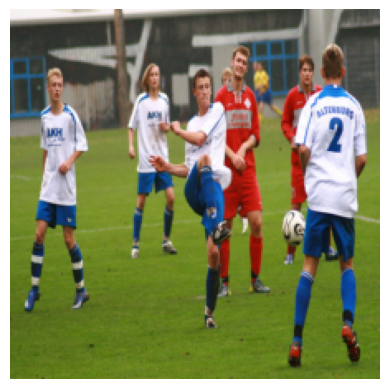

BLEU4 1.00000, BLEU3 1.00000, BLEU2 1.00000, BLEU1 1.00000): 

predicted caption: 
['<start>', 'a', 'dog', 'rolls', 'in', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 
['<start>', 'a', 'dog', 'rolls', 'in', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'small', 'white', 'dog', 'rolls', 'over', 'on', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'tan', 'dog', 'rolls', 'in', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'the', 'grey', 'dog', 'is', 'rolling', 'on', 'its', 'back', 'on', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>'

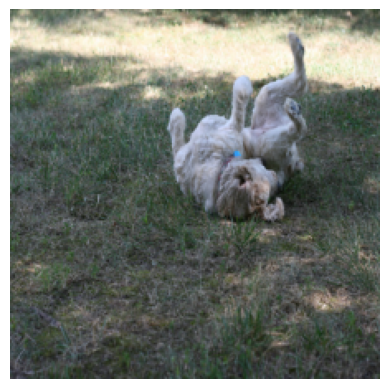

BLEU4 1.00000, BLEU3 1.00000, BLEU2 1.00000, BLEU1 1.00000): 

predicted caption: 
['<start>', 'a', 'grey', '<unk>', 'jumps', 'over', 'another', 'large', 'dog', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 
['<start>', 'a', 'grey', '<unk>', 'jumps', 'over', 'another', 'large', 'dog', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'one', 'grey', 'puddle', 'jumping', 'in', 'the', 'air', 'in', 'front', 'of', 'another', 'tan', 'dog', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'two', 'dogs', 'are', 'chasing', 'each', 'other', 'in', 'a', 'yard', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'two', 'dogs', 'playing', 'in', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

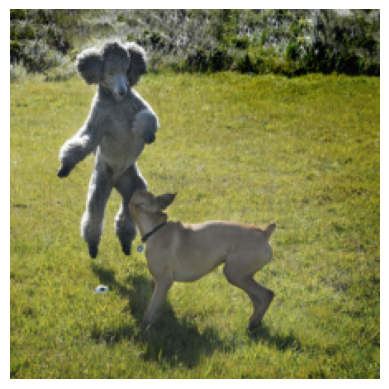

BLEU4 1.00000, BLEU3 1.00000, BLEU2 1.00000, BLEU1 1.00000): 

predicted caption: 
['<start>', 'a', 'couple', 'in', 'the', 'front', 'are', 'dancing', 'among', 'a', 'group', 'of', 'people', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 
['<start>', 'a', 'couple', 'in', 'the', 'front', 'are', 'dancing', 'among', 'a', 'group', 'of', 'people', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'couple', 'with', 'bright', 'hair', 'embracing', 'near', 'a', 'crowd', 'of', 'others', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'group', 'of', 'people', 'is', 'gathered', 'in', 'front', 'of', 'fountains', 'while', 'a', 'couple', 'wearing', 'leather', 'outfits', 'are', 'in', 'an', 'embrace', '<end>']
['<start>', 'a', 'group', 'of', 'young', 'adults', 'are', '<unk>', 'on', 'a', 'hot', 'day', 'in', 'a', 'park', 'with', 'a', 'fountain', 

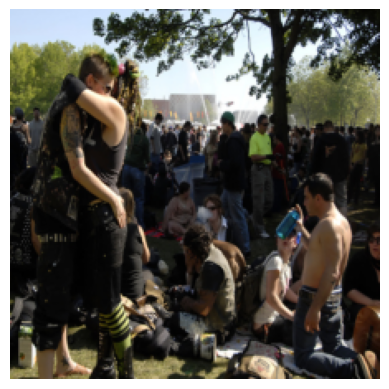

In [ ]:
# display the prediction result of small train set
model = ImageCaptioningModel(200, 256, len(vocab), max_len, 0, num_layers = 1) # (embed_dim, hidden_size, vocab_size, max_len, config['dropout_rate'], num_layers)
model_name = 'best_train_bleu1_model_0.00005_4_256_200_small__V1.pth'
data_loader = DataLoader(trainset_small, 4, shuffle=False, num_workers=2)
train_image_lst, train_pred_lst, train_true_lst, train_bleu1_lst, train_bleu2_lst, train_bleu3_lst, train_bleu4_lst = evaluation(model,model_name,data_loader, train_img_ids,'small',True, True)

The model could perfectly generate the captions on trainset. This suggests the model is able to learn the patterns on one batch data.

## 4.2 Compare ResNet50 and SqueezeNet1_0 (only result shown here)
I compared the model performance with two pretrained CNN models with their optimal initial learning rates. 

In [ ]:
url = "https://wandb.ai/weiping-zhang/dl_mc2/reports/ResNet50-vs-SqueezeNet1_0--Vmlldzo4MjUxMDc4"
IFrame(url, width=1000, height=500)

-   **Memory usage:** run with ResNet50 requires larger memory due to its larger amount of parameters. 
-   **BLEU**: Both models show improvements in BLEU scores in training. Run with ResNet50 has larger BLEU values than with SqueezeNet1_0. The difference on BLEU1 is quite small, but on n-gram BLEU scores are very significant. Higher n-gram BLEU scores reflect the ResNet50 could better extract the features from images, which improves the whole model's ability to generate contextually relevant sequence text.

Finally, I will use pretrained ResNet50 in my model.

## 4.3 Train model on large dataset

### 4.3.1 Tune learning rate & batch size on large dataset

In [ ]:
config = {
    'method': 'grid',
    'metric': {'name': 'Valid BLEU1', 'goal': 'maximize'},
    'parameters': {
        'model': {'values': ['cnn_rnn']}, 
        'data_type': {'values': ['large']},
        'batch_size': {'values': [32,64]},  
        'learning_rate': {'values': [0.001,0.0001]}, 
        'hidden_size': {'values': [256]},
        'num_layers': {'values': [1]},
        'embed_dim': {'values': [200]},
        'epochs': {'values': [15]},
        'dropout_rate': {'values': [0.5]},
        'lr_decay_rate': {'values':[0.9]},
        'early_stop_epochs': {'values': [15]},
        'update_lr_epochs': {'values': [2]},
        'save_model': {'values': ['resnet_V1']}
}}
display_wandb(config)

Create sweep with ID: czo4qx4w 
Sweep URL: https://wandb.ai/weiping-zhang/dl_mc2/sweeps/czo4qx4w


- The two runs with learning rate of 0.0001 have better performance in both train and validation sets than with learning rate of 0.001.
- Both two runs with learning rate of 0.0001 perform good in train set. However, the model with batch size of 64 has worse generalization on validation set than with smaller batch size of 32. The reason could be, larger batch size could increase the stablization and precision of gradient updates which may focus specifically too much on the training data when the batch size is too large. Smaller batch size could introduce more noise into the training process, which may help to get a better generalization on unseen data. In this case, batch size of 32 has a good balance of stablize gradient updates and generalize well on unseed data. 



### 4.3.2 train the model with only the first reference captions without image augmentation (old runs) 

### 4.3.3 train the model with random select one of the five reference captions + image augmentation

In [ ]:
# random captions + image augmentation
config = {
    'method': 'grid',
    'metric': {'name': 'Valid BLEU1', 'goal': 'maximize'},
    'parameters': {
        'model': {'values': ['cnn_rnn']}, 
        'data_type': {'values': ['large']},
        'batch_size': {'values': [32]},  
        'learning_rate': {'values': [0.00005]}, 
        'hidden_size': {'values': [256]},
        'num_layers': {'values': [1]},
        'embed_dim': {'values': [200]},
        'num_caption': {'values': [5]},  
        'epochs': {'values': [200]},
        'dropout_rate': {'values': [0.5]},
        'lr_decay_rate': {'values':[1]},
        'early_stop_epochs': {'values': [50]},
        'update_lr_epochs': {'values': [5]},
        'save_model': {'values': ['resnet_random_V1']}
        
}}
display_wandb(config)

Create sweep with ID: 5pv2b71e
Sweep URL: https://wandb.ai/weiping-zhang/dl_mc2/sweeps/5pv2b71e


Traceback (most recent call last):
  File "/var/folders/4r/tcytcqc56n3bcqfhnmthgtf80000gn/T/ipykernel_7702/3726975033.py", line 70, in train_eval
    loss.backward()
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/autograd/__init__.py", line 251, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Exception


In [ ]:
config = {
    'method': 'grid',
    'metric': {'name': 'Valid BLEU1', 'goal': 'maximize'},
    'parameters': {
        'model': {'values': ['cnn_rnn']}, 
        'data_type': {'values': ['large']},
        'batch_size': {'values': [32]},  
        'learning_rate': {'values': [0.0001]}, 
        'hidden_size': {'values': [256]},
        'num_layers': {'values': [1]},
        'embed_dim': {'values': [200]},
        'epochs': {'values': [150]},
        'dropout_rate': {'values': [0.5]},
        'lr_decay_rate': {'values':[0.9]},
        'early_stop_epochs': {'values': [50]},
        'update_lr_epochs': {'values': [2]},
        'log_batch': {'values': [False]},
        'save_model': {'values': ['resnet_150epochs_V1']}
}}
display_wandb(config)

Create sweep with ID: 3nekfx9j
Sweep URL: https://wandb.ai/weiping-zhang/dl_mc2/sweeps/3nekfx9j


wandb: Network error (ConnectionError), entering retry loop.
Traceback (most recent call last):
  File "/var/folders/4r/tcytcqc56n3bcqfhnmthgtf80000gn/T/ipykernel_84441/24078084.py", line 88, in train_eval
    loss.backward()
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/autograd/__init__.py", line 251, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Exception


The upper wandb Traceback information is due to manually stop the run from wandb page.

**Train loss** has a steady decrease, indicating the model is learning effectively from the training data. 

**Train BLEU scores**: BLEU scores (around BLEU1 at 0.38, BLEU2 at 0.1, BLEU3 at 0.04, BLEU4 at 0.015) on trainset decrease while the n-gram order increases as expected. But the scores especially the higher n-grams BLEU3, BLEU4 seem relatively low. This suggests model has difficulties in generating longer phrases and sentences. The reasons could be
-   training data diversity: Since my input data size is only 6400, this might be not diverse enough for the model to learn effective language patterns.
-   Model complexity: Though the model could learn very effective on small dataset, the suitable configuration on large dataset could be different. The improper configuration may cause the model not capture the language complexities to generate longer phrases and sentences.
-   Overfitting on some rare patterns: Due to my small input data size, there are probably many infrequent patterns. In the training process, models may memorize too much on them and lead bad performance on other patterns within the training set itself.

**Generalization**

- The train BLEU scores are generally higher than validation set. and have less fluctuation, indicating a good learning process on trainset.
- The Valid BLEU Scores are Lower and more inconstant, especially for higher n-grams (BLEU3, BLEU4). This may indicate that the model learns general patterns, but it struggles with more complex linguistic constructs or phrases which are not frequently appeared in the training set.
- The gaps between training and validation BLEU scores suggests model could well generalize on unseen data at the level of unigram, but generalize bad at higher n-grams(BLEU2, BLEU3, BLEU4).
- Good generalization at Unigrams (BLEU1) suggests that model is able to predict individual words that are likely to appear in the reference text. 
- Poor generalization at higher n-grams suggests that model is struggling with higher n-grams indicates challenges with understanding and generating correct word sequences and sentence structures. The model may not be effectively learning the contextual relationships between words, the syntactic rules of the language, or how words typically combine to form coherent phrases and sentences.


**Solutions**: To improve the model performance, the following strategies could be helpful:
-   Data Augmentation and use 5 reference captions for training: Since each image has five reference captions, I could apply image augmentations, so that each reference caption get paired with an unique image for training. This strategy will increase the diversity and volume of training data.

-   Randomly select four of the five reference captions (and the corresponding paired augmented images) for training in each epoch could improve the generalization. Because the training dataset is continously changing, the model can not memorize all details of the captions, because it sees slightly different input data each epoch.

-   However, due to limited time and RAM, I could not test the upper solutions currently.

### Analyse the predictions

In [ ]:
print("average BLEU1 of the whole dataset: 0.37995\naverage BLEU2 of the whole dataset: 0.11090\naverage BLEU3 of the whole dataset: 0.04236\naverage BLEU4 of the whole dataset: 0.01667\n--------------------")
print("\nbest BLEU4 1.00000, BLEU1 1.00000, BLEU2 1.00000, BLEU3 1.00000: \npredicted caption: \n['<start>','a', 'black', 'and', 'white', 'dog', 'is', '<end>', '<end>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] \n\nreference captions:\n\n['<start>', 'a', 'black', 'and', 'white', 'dog', 'is', 'swimming', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'dog', 'swims', 'in', 'the', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'dog', 'swims', 'through', 'deep', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'large', 'black', 'and', 'white', 'dog', 'is', 'swimming', 'in', 'the', 'water', '<end>', '<pad>', '<pad>', '<pad>']\n['<start>', 'the', 'black', 'and', 'white', 'dog', 'swims', 'with', 'a', 'brown', 'object', 'in', 'its', 'mouth', '<end>', '<pad>']")
img = mpimg.imread('test_1.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
print("--------------------\n")
print("best BLEU1 1.0, BLEU2 0.85714, BLEU3 0.66667, BLEU4 0.40000,:\npredicted caption: \n['a', 'brown', 'dog', 'is', 'jumping', 'through', 'the', 'grassy', '<end>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] \n\nreference captions: \n\n['<start>', 'a', 'brown', 'dog', 'is', 'flying', 'through', 'the', 'air', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'brown', 'dog', 'is', 'jumping', 'in', 'the', 'air', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'brown', 'dog', 'jumping', 'through', 'the', 'air', 'in', 'a', 'grassy', 'yard', '<end>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'large', 'tan', 'dog', 'jumps', 'in', 'the', 'air', 'over', 'the', 'grass', 'in', 'a', 'fenced', '<end>']\n['<start>', 'a', 'brown', 'dog', 'is', 'flying', 'through', 'the', 'air', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
")
img = mpimg.imread('test_2.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
print("--------------------\n")
print("best BLEU2 1.00000, (BLEU1 1.00000, BLEU3 0.66667, BLEU4 0.50000): \npredicted caption: \n['<start>', 'a', 'dog', 'wearing', 'a', 'white', '<end>', '<end>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] \n\nreference captions:\n\n['<start>', 'a', 'dog', 'wearing', 'a', 'collar', 'yawning', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'gray', 'dog', 'is', 'yawning', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'grey', 'dog', 'in', 'a', 'white', 'collar', 'yawning', 'with', 'its', 'eyes', 'closed', '<end>', '<pad>', '<pad>']\n['<start>', 'dog', 'with', 'white', 'collar', 'yawning', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'the', 'grey', 'dog', 'has', 'its', 'eyes', 'closed', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']")
img = mpimg.imread('test_3.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
print("--------------------\n")

print("best BLEU1 1.00000, (BLEU2 1.00000, BLEU3 0.80000, BLEU4 0.50000),: \npredicted caption: \n['<start>', 'a', 'brown', 'dog', 'is', 'running', 'through', 'the', '<end>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] \n\nreference captions: \n\n['<start>', 'a', 'brown', 'dog', 'is', 'running', 'on', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'brown', 'dog', 'is', 'running', 'very', 'fast', 'with', 'his', 'tongue', 'out', '<end>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'brown', 'dog', 'running', 'through', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'brown', 'dog', 'runs', 'on', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'brown', 'dog', 'runs', 'through', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']")
img = mpimg.imread('test_4.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

average BLEU1 of the whole dataset: 0.37995
average BLEU2 of the whole dataset: 0.11090
average BLEU3 of the whole dataset: 0.04236
average BLEU4 of the whole dataset: 0.01667
--------------------

best BLEU4 1.00000, BLEU1 1.00000, BLEU2 1.00000, BLEU3 1.00000: 
predicted caption: 
['<start>', 'a', 'black', 'and', 'white', 'dog', 'is', '<end>', '<end>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions:

['<start>', 'a', 'black', 'and', 'white', 'dog', 'is', 'swimming', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'dog', 'swims', 'in', 'the', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'dog', 'swims', 'through', 'deep', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'large', 'black', 'and', 'white', 'dog', 'is', 'swimming', 'in', 'the', 'water', '<end>', '<pad>', '<pad>', '<pad>']
['<sta

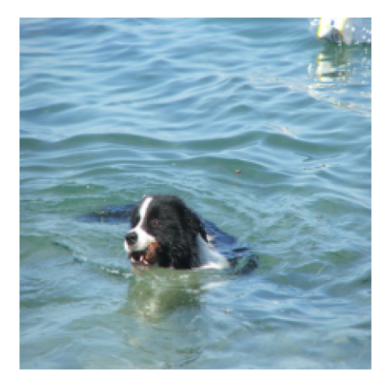

--------------------

best BLEU1 1.0, BLEU2 0.85714, BLEU3 0.66667, BLEU4 0.40000,:
predicted caption: 
['<start>', 'a', 'brown', 'dog', 'is', 'jumping', 'through', 'the', 'grassy', '<end>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 

['<start>', 'a', 'brown', 'dog', 'is', 'flying', 'through', 'the', 'air', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'is', 'jumping', 'in', 'the', 'air', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'jumping', 'through', 'the', 'air', 'in', 'a', 'grassy', 'yard', '<end>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'large', 'tan', 'dog', 'jumps', 'in', 'the', 'air', 'over', 'the', 'grass', 'in', 'a', 'fenced', '<end>']
['<start>', 'a', 'brown', 'dog', 'is', 'flying', 'through', 'the', 'air', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


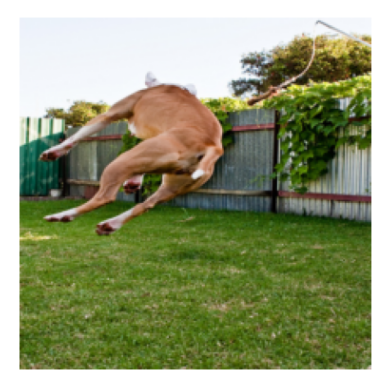

In [75]:
# train set
model = ImageCaptioningModel(200, 256, len(vocab), max_len, 0.5, num_layers = 1) # (embed_dim, hidden_size, vocab_size, max_len, dropout_rate, num_layers)
model_name = 'best_valid_bleu1_model_0.0001_32_256_200_large_resnet_150epochs_V1.pth'
data_loader = DataLoader(trainset, 32, shuffle=False, num_workers=2)
train_image_lst, train_pred_lst, train_true_lst, train_bleu1_lst, train_bleu2_lst, train_bleu3_lst, train_bleu4_lst = evaluation(model,model_name,data_loader, train_img_ids, True, True)


average BLEU1 of the whole dataset: 0.34239
average BLEU2 of the whole dataset: 0.01148
average BLEU3 of the whole dataset: 0.00016
average BLEU4 of the whole dataset: 0.00000
--------------------

best BLEU3 0.12783, BLEU1 0.69599, BLEU2 0.22371, BLEU4 0.00000: 
predicted caption: 
['a', 'black', 'dog', 'there', 'large', 'and', 'dog', 'a', 'of', '<end>', 'multicolor', 'elegant', 'guitarist', 'feathers', 'one', '<pad>'] 

reference captions:
 
['<start>', 'a', 'black', 'dog', 'chasing', 'another', 'black', 'dog', 'down', 'a', 'grass', 'covered', 'hill', '<end>', '<pad>', '<pad>']
['<start>', 'one', 'black', 'dog', 'and', 'one', '<unk>', 'color', 'dog', 'run', 'down', 'a', 'hill', '<end>', '<pad>', '<pad>']
['<start>', 'two', 'black', 'dogs', 'run', 'through', 'a', 'field', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'two', 'dogs', 'race', 'across', 'a', 'field', 'on', 'a', 'sunny', 'day', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', '

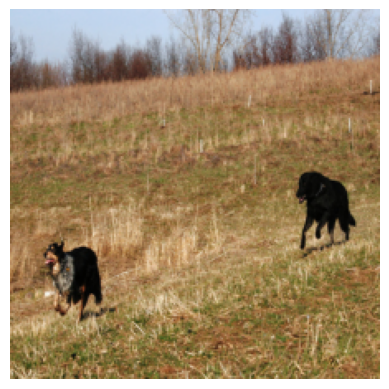

--------------------

best BLEU2 0.50000, BLEU1 0.71429, BLEU3 0.00000, BLEU4 0.00000: 
predicted caption: 
['a', 'black', 'and', 'dog', 'a', 'dog', 'over', '<end>', 'dolphins', 'sneakers', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions:
 
['<start>', 'a', 'black', 'dog', 'is', 'standing', 'with', 'his', 'legs', 'spread', 'wide', 'apart', 'on', 'some', 'sand', '<end>']
['<start>', 'a', 'dog', 'plays', 'on', 'a', 'beach', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'dog', 'plays', 'on', 'the', 'beach', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'an', '<unk>', 'dog', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'the', 'black', 'and', 'brown', 'dog', 'is', 'standing', 'with', 'its', 'legs', 'apart', 'on', 'the', 'beach', '<end>']


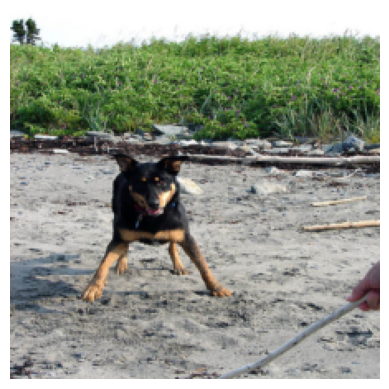

--------------------

best BLEU1 0.8888888888888888, BLEU2 0.12500, BLEU3 0.00000, BLEU4 0.00000,: 
predicted caption: 
['a', 'white', 'and', 'dog', 'jumping', 'an', 'top', 'a', 'in', '<end>', 'sneakers', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 

['<start>', 'a', 'dog', 'in', 'mid', 'flight', 'catches', 'an', 'orange', 'and', 'blue', 'ball', 'in', 'a', 'field', '<end>']
['<start>', 'a', 'dog', 'jumps', 'up', 'to', 'catch', 'an', 'orange', 'and', 'blue', 'tennis', 'ball', '<end>', '<pad>', '<pad>']
['<start>', 'a', 'dog', 'leaps', 'into', 'the', 'air', 'to', 'catch', 'a', 'ball', 'in', 'its', 'mouth', '<end>', '<pad>']
['<start>', 'a', 'terrier', 'catches', 'a', 'ball', 'in', 'a', 'field', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'small', 'white', 'dog', 'jumping', 'to', 'catch', 'a', 'ball', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


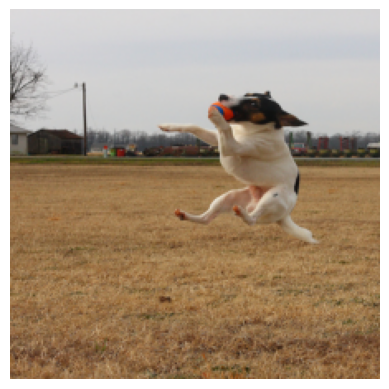

worst BLEU1 0,BLEU2 0.00000,BLEU3 0.00000,BLEU4 0.00000: 
predicted caption: 
['three', 'dogs', 'lady', 'these', 'around', 'grassy', 'beach', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 

['<start>', 'a', 'girl', 'climbing', 'a', 'tree', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'little', 'blond', 'girl', 'with', 'a', 'pink', 'coat', 'hides', 'in', 'a', 'tree', '<end>', '<pad>', '<pad>']
['<start>', 'a', 'little', 'blond', 'haired', 'girls', 'peers', 'at', 'the', 'camera', 'through', 'the', 'leaves', 'on', 'the', '<end>']
['<start>', 'a', 'young', 'girl', 'looking', 'down', 'through', 'some', 'leaves', 'from', 'atop', 'a', 'tree', '<end>', '<pad>', '<pad>']
['<start>', 'the', 'young', 'girl', 'happily', 'plays', 'in', 'the', 'tree', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


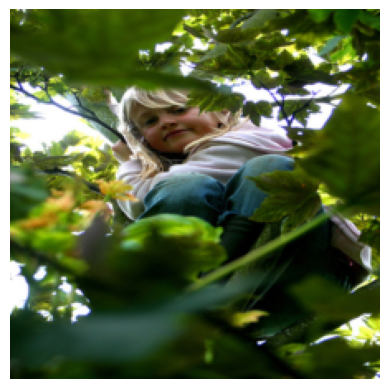

In [ ]:
# unseen test set
data_loader = DataLoader(testset, 32, shuffle=False, num_workers=2)
test_image_lst, test_pred_lst, test_true_lst, test_bleu1_lst, test_bleu2_lst, test_bleu3_lst, test_bleu4_lst = evaluation(model,model_name,data_loader, test_img_ids, True, False)

The good examples across all three dataset seem to have the same pattern format: a xx(color) dog. This means, the model could learn this pattern effectively and even generalize well on unseen data. The possible reason is this pattern has high frequency in data.

**Trainset example captions quality**: model could generate good quality captions for only a very small part of the train data. The reason could be, the training data is very diverse but small, the model don't have enough examples to learn effectively for the different (especially the low frequency) patterns.

**Testset example captions quality**: model is able to generate max. first three words correctly, but fails to generalize well for longer dependencies in the caption text. This suggests the model lacks of robust understandings.



# 5 Model V2: self train embedding matrix

Instead of using a pretrained word embeddings model, I would include the parameters from pre-trained embeddings into the training process and fine tune these parameters.
This approach could be powerful because it can learn more specific context of my dataset and generating better quality descriptions. But it may fit too well on my train dataset.

## 5.1 Update the DecoderRNN and train_eval function

Update the embeddings in the DecoderRNN architecture and parameters in Adam optimizer in train_eval function. 

In [40]:
# V2: trained the parameters of the pretrained GloVe embeddings
class DecoderRNN_2(nn.Module):
    def __init__(self, embed_dim, hidden_size, vocab_size, max_len, dropout_rate, num_layers):
        super(DecoderRNN_2, self).__init__()
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.max_len = max_len  # maximum sequence length
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_size) 
        self.fc = nn.Linear(hidden_size, vocab_size)
        ###################### HERE IS NEW ##########################
        self.embed = nn.Embedding(self.vocab_size, self.embed_dim) # meaning that each word in the vocabulary is represented by a n-dimensional random vector 
 
        # Set requires_grad to True to allow fine-tuning the embeddings parameters
        self.embed.weight.requires_grad = True
        ############################################################# 

    def forward(self, features, captions = None):
        
        ######### for training set: teacher forcing #########
        if captions is not None:
            batch_output_tensor = []
            
            # embed the caption indices with vectors
            embeddings = self.embed(captions)
            # add the features extracted from CNN, drop the last embedded word (either end or pad) because further prediction is not needed.
            embeddings = torch.cat((features.unsqueeze(1), embeddings[:,:-1,:]), dim=1) # shape( batch_size, max_len, embed_dim)
            lstm_out, _ = self.lstm(embeddings) # lstm_out shape: (batch_size, max_len, hidden_size)
            lstm_out = self.layer_norm(lstm_out)
            
            batch_output_tensor = self.fc(lstm_out)# probability output shape: (batch_size, max_len, vocab_size)
        
        ######### for validation set: #########
        if captions is None:
            input_tensor = features.unsqueeze(1) # first input (batch_size, 1, embed_dim)
            output_lst = []  # to concate all outputs (intotal max_len outputs)
            all_output_indices = [] 
            states = None  # store LSTM states
            
            for i in range(self.max_len):
                lstm_out, states = self.lstm(input_tensor, states)
                lstm_out = self.layer_norm(lstm_out)
                output_tensor = self.fc(lstm_out) # (batch_size, 1, vocab_size)
                output_lst.append(output_tensor)

                # convert output to indices -> as input for the next iteration
                output_indices = torch.argmax(output_tensor, dim=2) # (batch_size, 1)
                all_output_indices.append(output_indices)
                if self.embed_dim == 100:
                    input_tensor = vocab_emb_100[output_indices] # (batch_size, 1, 100) 
                if self.embed_dim == 200:
                    input_tensor = vocab_emb_200[output_indices] # (batch_size, 1, 200) 
  
            batch_output_tensor = torch.cat(output_lst, dim=1)  # (batch_size, max_len, vocab_size)
  
        return batch_output_tensor

class ImageCaptioningModel_2(nn.Module):
    def __init__(self, embed_dim, hidden_size, vocab_size, max_len, dropout_rate, num_layers):
        super(ImageCaptioningModel_2, self).__init__()
        self.encoder = EncoderCNN(embed_dim)
        self.decoder = DecoderRNN_2(embed_dim, hidden_size, vocab_size, max_len, dropout_rate, num_layers)

    def forward(self, images, captions=None):
        features = self.encoder(images)
        if captions != None:
            outputs = self.decoder(features,captions)
        if captions == None:
            outputs = self.decoder(features)
        return outputs

In [41]:
# V2: 

def train_eval(config):
    with wandb.init(project='dl_mc2', entity='weiping-zhang', config=config) as run:
        config = run.config
        embed_dim = config['embed_dim'] 
        num_layers = config['num_layers']
        hidden_size = config['hidden_size']
        data_type = config['data_type'] 
        dropout_rate = config['dropout_rate']
        lr_decay_rate = config['lr_decay_rate']
        vocab_size = len(vocab) 
        best_train_loss = float('inf')
        best_valid_bleu1 = 0
        learning_rate = config['learning_rate']
        batch_size = config['batch_size']
        early_stop_epochs = config['early_stop_epochs']
        save_model = config['save_model']
        model_name = f"{learning_rate}_{batch_size}_{hidden_size}_{embed_dim}_{data_type}_{config['model']}_{save_model}"  # trained model will be saved with this name
        
        early_stop_counter, early_stop_counter, update_lr_counter, best_train_bleu1 = 0, 0, 0, 0
    
        # load data
        if data_type == 'small':
            train_loader = DataLoader(trainset_small, batch_size=batch_size, shuffle=True, num_workers=2)
            valid_loader = DataLoader(validset_small, batch_size=batch_size, shuffle=False, num_workers=2)
        elif data_type == 'large': 
            train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
            valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)
            
        # model
        if config['model'] == 'cnn_rnn':
            model = ImageCaptioningModel(embed_dim, hidden_size, vocab_size, max_len, dropout_rate, num_layers)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            
        ###################### HERE IS NEW ##########################        
        elif config['model'] == 'train_embed':
            model = ImageCaptioningModel_2(embed_dim, hidden_size, vocab_size, max_len, dropout_rate, num_layers)
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
        ############################################################# 
        
        # define the loss with reduction='sum', meaning that the loss is the sum of the batch losses
        criterion = nn.CrossEntropyLoss(reduction='sum')

        for epoch in range(config['epochs']):
            ################ train process ################
            model.train()
            for param in model.parameters():
                param.requires_grad = True
            sum_epoch_loss, sum_epoch_bleu1, sum_epoch_bleu2, sum_epoch_bleu3, sum_epoch_bleu4, count_train = 0.0, 0.0, 0.0, 0.0, 0.0, 0


            # determine how many captions per image to use
            if config['num_caption'] ==1: # for overfitting test: use the first caption for all images in the batch
                idx_cap = 0
            else:
                idx_cap = epoch%config['num_caption'] # for each epoch, use a different caption for all images in the batch
                # idx_cap = random.randint(0, config['num_caption']) # randomly select a caption group for all images in the batch
            
            for n,batch in enumerate(train_loader):
               
                images, caption_indices_5 = batch # images shape: (batch_size,3,224,224), caption_indices shape: (batch_size, 5, max_len)
                                               
                num_img = images.shape[0]
                count_train += num_img

                images = augmentation(images)   
                caption_indices = caption_indices_5[:,idx_cap,:]  # the i-th of the total 5 captions for each batch, shape (batch_size, max_len)

                # True probabilities: each true index is represented with a vector, with 1 at the true index and rest are 0.
                true_prob = torch.zeros(caption_indices.shape[0], caption_indices.shape[1], len(vocab)) # (batch_size, max_len, vocab_size)
                true_prob = true_prob.scatter_(2, caption_indices.unsqueeze(2), 1) # (batch_size, max_len, vocab_size)
                
                # forward pass
                optimizer.zero_grad()
                pred_prob = model(images, caption_indices) # predicted probabilities shape (batch_size, max_len, vocab_size)

                # loss: between predicted caption and reference caption
                loss = criterion(pred_prob, true_prob)/num_img  # average loss per image, as the last batch may have less images
                loss.backward()
                optimizer.step()

                # add up the batch loss () to epoch loss 
                sum_epoch_loss += loss*num_img

                # BLEU calculation: predicted caption and 5 reference captions
                true_indices_lst = caption_indices_5.detach().numpy().tolist() # (batch_size, 5, max_len)
                pred_indices_lst = torch.argmax(pred_prob, dim=2).numpy().tolist() # (batch_size, max_len)
   
                # iterate over each image in the batch
                for i in range(len(true_indices_lst)): 
                
                    # keep only the captions between start and end tokens, exclude start, end, pad tokens
                    true_indices_i = [extract_before_end(caption) for caption in true_indices_lst[i]] # nested list shape (5, < max_len)
                    pred_indices_i = extract_before_end(pred_indices_lst[i]) # list shape with length < max_len
                    
                    bleu_score1 = sentence_bleu(true_indices_i, pred_indices_i, weights=(1, 0, 0, 0))
                    bleu_score2 = sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 1, 0, 0))
                    bleu_score3 = sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 0, 1, 0))
                    bleu_score4 = sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 0, 0, 1))
         
                    # add up the BLEU scores (per image) to the epoch BLEU
                    sum_epoch_bleu1 += bleu_score1
                    sum_epoch_bleu2 += bleu_score2
                    sum_epoch_bleu3 += bleu_score3
                    sum_epoch_bleu4 += bleu_score4
                    

            wandb.log({'Train Loss': sum_epoch_loss / count_train, 'Train BLEU1': sum_epoch_bleu1 / count_train, 'Train BLEU2': sum_epoch_bleu2 / count_train, 'Train BLEU3': sum_epoch_bleu3 / count_train, 'Train BLEU4': sum_epoch_bleu4 / count_train, 'lr': optimizer.param_groups[0]['lr']},step=epoch)


           # save the model every 3 epochs and the best model
            if epoch % 3 == 0:
                torch.save(model.state_dict(), f'model_{model_name}_{epoch}.pth')

           # for small set based on train bleu1
            epoch_train_bleu1 = sum_epoch_bleu1 / count_train
            if data_type == 'small' and epoch_train_bleu1 > best_train_bleu1:
                torch.save(model.state_dict(), f'best_train_bleu1_model_{model_name}.pth')

            # early stopping
            if data_type == 'small' and sum_epoch_bleu4 / count_train == 1:
                print(f"Early stopping because BLEU4 is 1")
                break

            # update learning rate 
            #average_epoch_loss = sum_epoch_loss / count_train
            if epoch_train_bleu1 > best_train_bleu1: 
                best_train_bleu1 = epoch_train_bleu1
                update_lr_counter = 0     
            else:
                update_lr_counter += 1  
            # 1. update learning rate by 0.5
            if update_lr_counter >= config['update_lr_epochs']:
                learning_rate *= 0.5
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                update_lr_counter = 0
            # 2. update learning rate by lr_decay_rate (usually between 0.9 - 1)
            else:
                learning_rate *= lr_decay_rate
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                
            
            ################ evaluation process ################
            model.eval()
            sum_epoch_loss, sum_epoch_bleu1, sum_epoch_bleu2, sum_epoch_bleu3, sum_epoch_bleu4, count_valid = 0.0, 0.0, 0.0, 0.0, 0.0, 0
            with torch.no_grad():
                for batch in valid_loader:
                    images, caption_indices = batch # images shape: (batch_size,3,224,224), caption_indices shape: (batch_size, 5, max_len)
                    num_img = images.shape[0]
                    count_valid += num_img

                    true_prob = torch.zeros(caption_indices.shape[0], caption_indices.shape[1], caption_indices.shape[2], len(vocab)) # (batch_size, 5, max_len, vocab_size)
                    true_prob = true_prob.scatter_(3, caption_indices.unsqueeze(3), 1) # (batch_size, 5, max_len, vocab_size)
                
                    pred_prob = model(images)  # predicted probabilities (batch_size, max_len, vocab_size)
                 
                    # BLEU calculation
                    true_indices_lst = caption_indices.detach().numpy().tolist() # (batch_size, 5, max_len)
                    pred_indices = torch.argmax(pred_prob, dim=2).detach().numpy().tolist() # (batch_size, max_len)
                    
                    ## iterate over each image in the batch
                    for i in range(len(true_indices_lst)): 
                        # keep only the captions between start and end tokens, exclude start, end, pad tokens
                        true_indices_i = [extract_before_end(caption) for caption in true_indices_lst[i]] # 5 reference captions: nested list shape (5, < max_len)
                        pred_indices_i = extract_before_end(pred_indices[i]) # 1 predicted caption: list with length < max_len
                      
                        bleu_score1 = (sentence_bleu(true_indices_i, pred_indices_i, weights=(1, 0, 0, 0)))
                        bleu_score2 = (sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 1, 0, 0)))
                        bleu_score3 = (sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 0, 1, 0)))
                        bleu_score4 = (sentence_bleu(true_indices_i, pred_indices_i, weights=(0, 0, 0, 1)))
        
                        # add the BLEU scores per image to the epoch BLEUs
                        sum_epoch_bleu1 += bleu_score1
                        sum_epoch_bleu2 += bleu_score2
                        sum_epoch_bleu3 += bleu_score3
                        sum_epoch_bleu4 += bleu_score4
    
                        # loss for validation set
                        # for each image, take the smallest loss of the five losses (calculated with 5 reference captions)
                        loss_5_lst = []
                        for j in range(5): #  iterate over 5 reference captions
                            loss = criterion(pred_prob[i,:,:], true_prob[i,j,:,:])
                            loss_5_lst.append(loss)
                        sum_epoch_loss += np.min(loss_5_lst)
        
                epoch_valid_bleu1 = sum_epoch_bleu1 / count_valid
                wandb.log({'Valid Loss': sum_epoch_loss / count_valid, 'Valid BLEU1': sum_epoch_bleu1 / count_valid, 'Valid BLEU2': sum_epoch_bleu2 / count_valid, 'Valid BLEU3': sum_epoch_bleu3 / count_valid, 'Valid BLEU4': sum_epoch_bleu4 / count_valid},step=epoch)
    
                
                # check early stopping for large dataset (only when the model is not underfitting), it is based on valid BLEU1
                
                if data_type == 'large'  and epoch_valid_bleu1 < epoch_train_bleu1:
                    if epoch_valid_bleu1 > best_valid_bleu1:
                        best_valid_bleu1 = epoch_valid_bleu1
                        early_stop_counter = 0
                        
                        # save the best model based on valid BLEU1
                        torch.save(model.state_dict(), f'best_valid_bleu1_model_{model_name}.pth')
                        
                    elif epoch_valid_bleu1 <= best_valid_bleu1: 
                        early_stop_counter += 1
                        
                    if early_stop_counter >= early_stop_epochs: 
                        print('Early stop!')
                        break
   
            

## 5.2 Overfitting test with only the first caption

In [ ]:
# one batch 256-256
config = {
    'method': 'grid',
    'metric': {'name': 'Train BLEU1', 'goal': 'maximize'},
    'parameters': {
        'model': {'values': ['train_embed']}, 
        'data_type': {'values': ['small']},
        'batch_size': {'values': [4]},  
        'learning_rate': {'values': [0.0001]}, 
        'hidden_size': {'values': [256]},
        'num_layers': {'values': [1]},
        'embed_dim': {'values': [256]},
        'num_caption': {'values': [False]},
        'epochs': {'values': [100]},
        'dropout_rate': {'values': [0]},
        'lr_decay_rate': {'values':[0.999]},
        'early_stop_epochs': {'values': [30]},
        'update_lr_epochs': {'values': [5]},
        'save_model': {'values': ['resnet_V2']}
}}
display_wandb(config)

Create sweep with ID: udphl3d3
Sweep URL: https://wandb.ai/weiping-zhang/dl_mc2/sweeps/udphl3d3


Early stopping because BLEU4 is 1


average BLEU1 of the whole dataset: 0.98214
average BLEU2 of the whole dataset: 0.98077
average BLEU3 of the whole dataset: 0.97917
average BLEU4 of the whole dataset: 0.97727
BLEU4 1.00000, BLEU3 1.00000, BLEU2 1.00000, BLEU1 1.00000): 

predicted caption: 
['<start>', 'a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 
['<start>', 'a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'black', 'dog', 'and', 'a', 'tri', 'colored', 'dog', 'playing', 'with', 'each', 'other', 'on', 'the', 'road', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'black', 'dog', 'and', 'a', 'white', 'dog', 'with', 'brown', 'spots', 'are', 'staring', 'at', 'each', 'other', 'in', 'the', 'street', '<end>

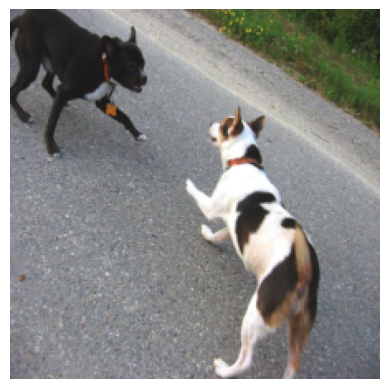

BLEU4 1.00000, BLEU3 1.00000, BLEU2 1.00000, BLEU1 1.00000): 

predicted caption: 
['<start>', 'three', 'people', 'stand', 'by', 'a', 'doorway', 'posing', 'for', 'a', 'photograph', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 
['<start>', 'three', 'people', 'stand', 'by', 'a', 'doorway', 'posing', 'for', 'a', 'photograph', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'two', 'men', 'and', 'a', 'woman', 'pose', 'for', 'a', 'picture', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'two', 'men', 'and', 'a', 'woman', 'smile', 'at', 'the', 'camera', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'two', 'men', 'and', 'a', 'woman', 'standing', 'near', 'a', 'doorway', '<end>', '<pad>', '<pad>', '<pad>', '<pad>',

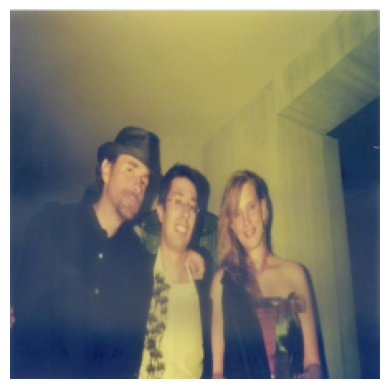

BLEU4 0.90909, BLEU3 0.91667, BLEU2 0.92308, BLEU1 0.92857): 

predicted caption: 
['<start>', 'woman', 'woman', 'in', 'a', 'pink', 'hat', 'and', 'a', 'navy', 'blue', 'coat', 'riding', 'a', 'bicycle', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 
['<start>', 'a', 'woman', 'in', 'a', 'pink', 'hat', 'and', 'a', 'navy', 'blue', 'coat', 'riding', 'a', 'bicycle', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'woman', 'wearing', 'a', 'pink', 'cap', 'riding', 'a', 'bicycle', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'woman', 'with', 'glasses', 'and', 'a', 'pink', 'hat', 'rides', 'her', 'bike', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'the', 'woman', 'is', 'wearing', 'a', 'pink', 'hat', 'and', 'is', 'riding', 'a', 'bike', 'in', 'the', 'park', '<end>', '<pad>', '<pad>', '<pad>', '

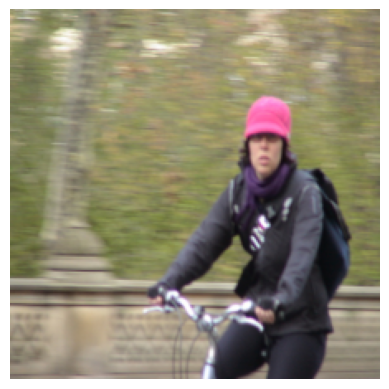

BLEU4 1.00000, BLEU3 1.00000, BLEU2 1.00000, BLEU1 1.00000): 

predicted caption: 
['<start>', 'a', 'family', 'is', 'looking', 'through', '<unk>', 'at', 'a', 'city', 'over', 'a', 'body', 'of', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 
['<start>', 'a', 'family', 'is', 'looking', 'through', '<unk>', 'at', 'a', 'city', 'over', 'a', 'body', 'of', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', '<unk>', 'look', 'across', 'the', 'water', 'at', 'a', 'city', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'three', 'people', 'are', 'standing', 'at', 'a', 'fence', 'looking', 'at', 'a', 'skyscraper', 'filled', 'city', 'while', 'one', 'looks', 'through', 'a', '<unk>', '<unk>', '<end>']
['<start>', 'three', 'people', 'lean', 'against', 'a', 'railing', 'and', 'look', 'at', 'buildings', 'across', 'the', 'water', '<end>', '<pad>', '<p

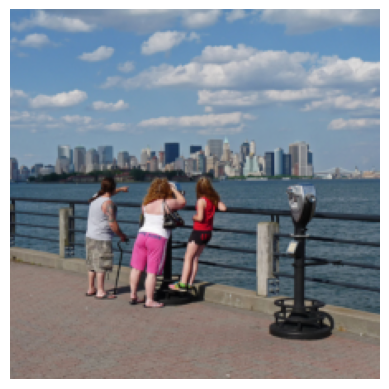

In [ ]:
# one batch trainset
model = ImageCaptioningModel_2(256, 256, len(vocab), max_len, 0, num_layers = 1) # (embed_dim, hidden_size, vocab_size, max_len, config['dropout_rate'], num_layers)
model_name = 'best_train_bleu1_model_0.0001_4_256_256_small_train_embed_resnet_V2.pth'
data_loader = DataLoader(trainset_small, 4, shuffle=False, num_workers=2)
train_image_lst, train_pred_lst, train_true_lst, train_bleu1_lst, train_bleu2_lst, train_bleu3_lst, train_bleu4_lst = evaluation(model,model_name,data_loader, train_img_ids, 'small',True, True)

Model is able to reach 100% BLEU scores on a single batch with the first reference caption. This indicates model have enough parameters and architectural complexity to capture all the details of the data it's trained on.


## 5.3 Train on small dataset with random caption selection and image augmentation

In [ ]:
# with image augmentation and random caption selection 256-256
config = {
    'method': 'grid',
    'metric': {'name': 'Train BLEU1', 'goal': 'maximize'},
    'parameters': {
        'model': {'values': ['train_embed']}, 
        'data_type': {'values': ['small']},
        'batch_size': {'values': [4]},  
        'learning_rate': {'values': [0.0001]}, 
        'hidden_size': {'values': [256]},
        'num_layers': {'values': [1]},
        'embed_dim': {'values': [256]},
        'num_caption': {'values': [True]},
        'epochs': {'values': [500]},
        'dropout_rate': {'values': [0]},
        'lr_decay_rate': {'values':[1]},  # use fixed learning rate without decay
        'early_stop_epochs': {'values': [30]},
        'update_lr_epochs': {'values': [20]},
        'save_model': {'values': ['resnet_V2']}
}}
display_wandb(config)

Create sweep with ID: 5yjaslsq
Sweep URL: https://wandb.ai/weiping-zhang/dl_mc2/sweeps/5yjaslsq


Early stopping because BLEU4 is 1


-   Even with random caption selection, the model could still make perfect prediction on trainset, indicating self-training embeddings mightbe powerful in this cases.
-   The train loss and BLEU score curves are very noisy. This is because model is training on different reference captions and augmented images in each epoch.


## 5.3 Train on full dataset with first reference captions (old model)
Start with the same config as the final run in model V1, though the suitable learning rate could be slightly different due to increased volume of parameters to be trained. 

In [ ]:
# first caption and no augmentation
config = {
    'method': 'grid',
    'metric': {'name': 'Valid BLEU1', 'goal': 'maximize'},
    'parameters': {
        'model': {'values': ['train_embed']}, 
        'data_type': {'values': ['large']},
        'batch_size': {'values': [32]},  
        'learning_rate': {'values': [0.0001]}, 
        'hidden_size': {'values': [256]},
        'num_layers': {'values': [1]},
        'embed_dim': {'values': [200]},
        'epochs': {'values': [150]},
        'dropout_rate': {'values': [0.5]},
        'lr_decay_rate': {'values':[0.9]},
        'early_stop_epochs': {'values': [50]},
        'update_lr_epochs': {'values': [2]},
        'save_model': {'values': ['resnet_150epochs_V2']}
}}
display_wandb(config)

Create sweep with ID: nlusv328
Sweep URL: https://wandb.ai/weiping-zhang/dl_mc2/sweeps/nlusv328


### Analyse prediction examples

average BLEU1 of the whole dataset: 0.38924
average BLEU2 of the whole dataset: 0.10538
average BLEU3 of the whole dataset: 0.03768
average BLEU4 of the whole dataset: 0.01517
--------------------

best BLEU4 1.00000 (BLEU1 1.00000, BLEU2 1.00000, BLEU3 1.00000): 
predicted caption: 
['<start>', 'a', 'black', 'and', 'white', 'dog', 'is', '<end>', '<end>', '<end>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions:

['<start>', 'a', 'black', 'and', 'white', 'dog', 'is', 'playing', 'in', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'black', 'dog', 'is', 'standing', 'on', 'a', 'step', 'next', 'to', 'a', 'river', 'at', 'it', '<end>']
['<start>', 'a', 'dog', 'is', 'shaking', 'after', 'coming', 'out', 'of', 'the', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'dog', 'is', 'shaking', 'water', 'off', 'of', 'itself', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'dog', 'shakes'

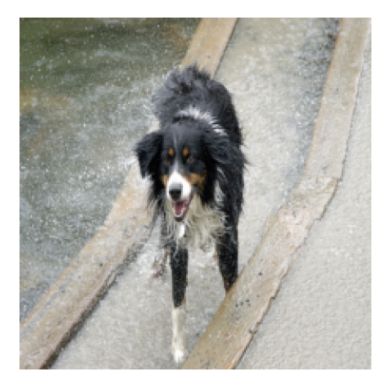

--------------------

best BLEU3 1.00000, (BLEU1 1.00000, BLEU2 1.00000, BLEU4 1.00000): 
predicted caption: 
['a', 'black', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', '<end>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions:

['<start>', 'a', 'black', 'and', 'white', 'dog', 'is', 'running', 'through', 'shallow', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'black', 'and', 'white', 'dog', 'runs', 'through', 'the', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'black', 'and', 'white', 'dog', 'running', 'through', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'the', 'black', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'water', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'this', 'dog', 'is', 'running', 'through', 'water', 'on', 'a', 'beach', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


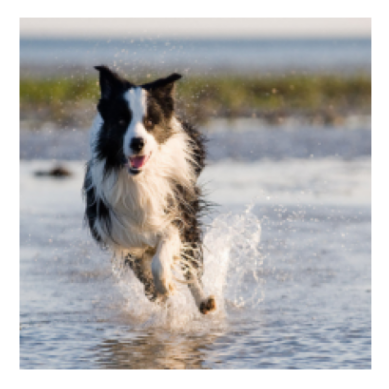

--------------------

best BLEU2 1.00000, (BLEU1 1.00000, BLEU3 0.66667, BLEU4 0.50000): 
predicted caption: 
['<start>', 'a', 'dog', 'wearing', 'a', 'white', '<end>', '<end>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions:

['<start>', 'a', 'dog', 'wearing', 'a', 'collar', 'yawning', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'gray', 'dog', 'is', 'yawning', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'grey', 'dog', 'in', 'a', 'white', 'collar', 'yawning', 'with', 'its', 'eyes', 'closed', '<end>', '<pad>', '<pad>']
['<start>', 'dog', 'with', 'white', 'collar', 'yawning', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'the', 'grey', 'dog', 'has', 'its', 'eyes', 'closed', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


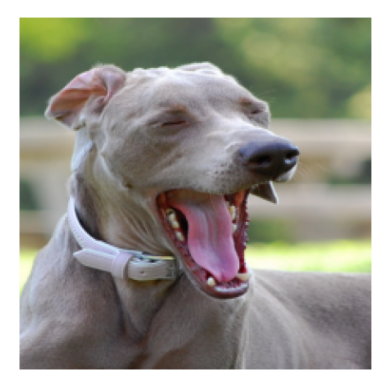

--------------------

best BLEU1 1.00000, (BLEU2 1.00000, BLEU3 0.80000, BLEU4 0.50000),: 
predicted caption: 
['<start>', 'a', 'brown', 'dog', 'is', 'running', 'through', 'the', '<end>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 

['<start>', 'a', 'brown', 'dog', 'is', 'running', 'on', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'is', 'running', 'very', 'fast', 'with', 'his', 'tongue', 'out', '<end>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'running', 'through', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'runs', 'on', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'runs', 'through', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


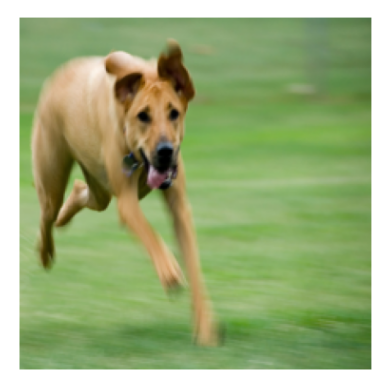

In [67]:
model = ImageCaptioningModel_2(200, 256, len(vocab), max_len, 0.5, num_layers = 1) # (embed_dim, hidden_size, vocab_size, max_len, config['dropout_rate'], num_layers)
model_name = 'best_valid_bleu1_model_0.0001_32_256_200_large_train_embed_resnet_150epochs_V2_epoch27.pth'
data_loader = DataLoader(trainset, 32, shuffle=False, num_workers=2)
train_image_lst, train_pred_lst, train_true_lst, train_bleu1_lst, train_bleu2_lst, train_bleu3_lst, train_bleu4_lst = evaluation(model,model_name,data_loader, train_img_ids, True, True)


## 5.4 Train on full dataset with random caption selection and image augmentation

In [ ]:
# full dataset: use random caption selection + image augmentation 256-256
config = {
    'method': 'grid',
    'metric': {'name': 'Valid BLEU1', 'goal': 'maximize'},
    'parameters': {
        'model': {'values': ['train_embed']}, 
        'data_type': {'values': ['large']},
        'batch_size': {'values': [32]},  
        'learning_rate': {'values': [0.0001]}, 
        'hidden_size': {'values': [256]},
        'num_layers': {'values': [1]},
        'embed_dim': {'values': [256]},
        'num_caption': {'values': [True]},
        'epochs': {'values': [500]},
        'dropout_rate': {'values': [0.5]},
        'lr_decay_rate': {'values':[1]},  # use fixed learning rate without decay
        'early_stop_epochs': {'values': [50]},
        'update_lr_epochs': {'values': [2]},
        'save_model': {'values': ['resnet_randomcaptions_V2']}
}}
display_wandb(config)

Create sweep with ID: uq3n05hr
Sweep URL: https://wandb.ai/weiping-zhang/dl_mc2/sweeps/uq3n05hr


Traceback (most recent call last):
  File "/var/folders/4r/tcytcqc56n3bcqfhnmthgtf80000gn/T/ipykernel_5587/333128359.py", line 73, in train_eval
    pred_prob = model(images, caption_indices) # predicted probabilities shape (batch_size, max_len, vocab_size)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/var/folders/4r/tcytcqc56n3bcqfhnmthgtf80000gn/T/ipykernel_5587/3509084611.py", line 70, in forward
    features = self.encoder(images)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/rheinpark/Desktop/.conda/lib/python3.10/site-packages/torch/nn/module

In [47]:
image.png

NameError: name 'image' is not defined

average BLEU1 of the whole dataset: 0.33586
average BLEU2 of the whole dataset: 0.01963
average BLEU3 of the whole dataset: 0.00071
average BLEU4 of the whole dataset: 0.00000
--------------------

best BLEU3 0.26360, (BLEU1 0.26360, BLEU2 0.26360, BLEU4 0.00000): 
predicted caption: 
['<start>','a', 'brown', 'dog', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions:

['<start>', 'a', 'brown', 'dog', 'digs', 'in', 'the', 'sand', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'is', 'digging', 'in', 'the', 'dirt', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'with', 'a', 'brown', 'collar', 'digging', 'in', 'the', 'sand', '<end>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'with', 'a', 'brown', 'collar', 'digs', 'sand', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a'

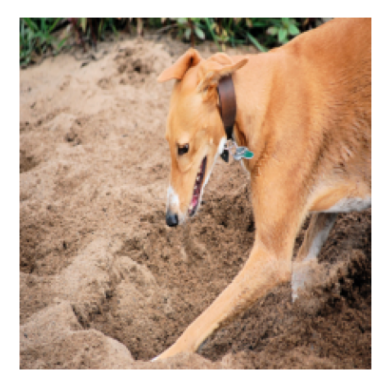

--------------------

best BLEU2 0.36788, (BLEU1 0.36788, BLEU3 0.00000, BLEU4 0.00000):
predicted caption: 
['<start>', 'a', 'man', 'on', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions:

['<start>', 'a', 'biker', 'bikes', 'in', 'the', 'mountains', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'male', 'bicyclist', 'on', 'a', 'mountain', 'road', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'man', 'biking', 'in', 'front', 'of', 'mountains', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'man', 'is', 'biking', 'down', 'really', 'rough', 'terrain', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'man', 'on', 'bicycle', '<unk>', 'high', 'in', 'the', 'mountains', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


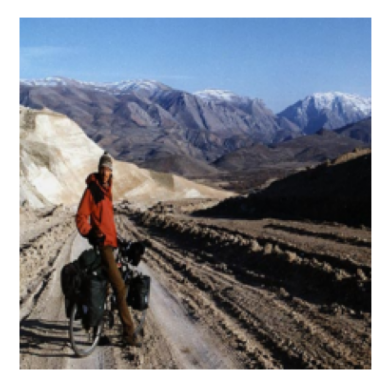

--------------------

best BLEU1 1.00000, (BLEU2 0.00000, BLEU3 0.00000, BLEU4 0.00000),: 
predicted caption: 
['<start>', 'a', 'and', 'dog', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 

['<start>', 'a', 'dog', 'jumps', 'onto', 'the', 'sidewalk', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'small', 'dog', 'runs', 'from', 'the', 'dirt', 'onto', 'the', 'street', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'dog', 'leaps', 'out', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'the', 'brown', 'and', 'white', 'dog', 'is', 'standing', 'on', 'its', 'hind', 'legs', 'beside', 'the', 'path', '<end>']
['<start>', 'a', 'dog', 'jumps', 'onto', 'the', 'sidewalk', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


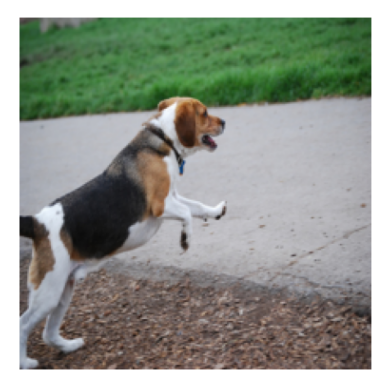

--------------------

best BLEU1 1.00000, (BLEU2 0.00000, BLEU3 0.00000, BLEU4 0.00000),: 
predicted caption: 
['<start>', 'a', 'and', 'dog', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 

['<start>', 'a', 'dog', 'jumps', 'onto', 'the', 'sidewalk', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'small', 'dog', 'runs', 'from', 'the', 'dirt', 'onto', 'the', 'street', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'dog', 'leaps', 'out', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'the', 'brown', 'and', 'white', 'dog', 'is', 'standing', 'on', 'its', 'hind', 'legs', 'beside', 'the', 'path', '<end>']
['<start>', 'a', 'dog', 'jumps', 'onto', 'the', 'sidewalk', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


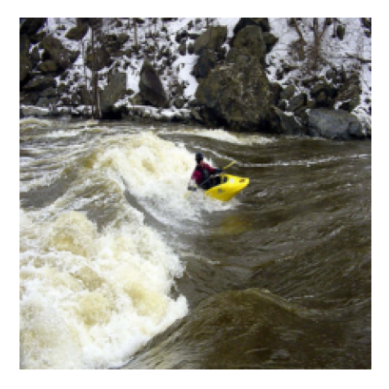

In [60]:
# test set
data_loader = DataLoader(testset, 32, shuffle=False, num_workers=2)
test_image_lst, test_pred_lst, test_true_lst, test_bleu1_lst, test_bleu2_lst, test_bleu3_lst, test_bleu4_lst = evaluation(model,model_name,data_loader, test_img_ids, True, False)


print("average BLEU1 of the whole dataset: 0.33586\naverage BLEU2 of the whole dataset: 0.01963\naverage BLEU3 of the whole dataset: 0.00071\naverage BLEU4 of the whole dataset: 0.00000\n--------------------\n\nbest BLEU3 0.26360, (BLEU1 0.26360, BLEU2 0.26360, BLEU4 0.00000): \npredicted caption: \n['<start>','a', 'brown', 'dog', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] \n\nreference captions:\n\n['<start>', 'a', 'brown', 'dog', 'digs', 'in', 'the', 'sand', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'brown', 'dog', 'is', 'digging', 'in', 'the', 'dirt', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'brown', 'dog', 'with', 'a', 'brown', 'collar', 'digging', 'in', 'the', 'sand', '<end>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'brown', 'dog', 'with', 'a', 'brown', 'collar', 'digs', 'sand', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'dog', 'is', 'digging', 'a', 'hole', 'in', 'the', 'dirt', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n")
img = mpimg.imread('test_1.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
print("--------------------\n")
print("best BLEU2 0.36788, (BLEU1 0.36788, BLEU3 0.00000, BLEU4 0.00000):\npredicted caption: \n['<start>', 'a', 'man', 'on', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] \n\nreference captions:\n\n['<start>', 'a', 'biker', 'bikes', 'in', 'the', 'mountains', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'male', 'bicyclist', 'on', 'a', 'mountain', 'road', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'man', 'biking', 'in', 'front', 'of', 'mountains', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'man', 'is', 'biking', 'down', 'really', 'rough', 'terrain', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'man', 'on', 'bicycle', '<unk>', 'high', 'in', 'the', 'mountains', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']")
img = mpimg.imread('test_2.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
print("--------------------\n")
print("best BLEU1 1.00000, (BLEU2 0.00000, BLEU3 0.00000, BLEU4 0.00000),: \npredicted caption: \n['<start>', 'a', 'and', 'dog', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] \n\nreference captions: \n\n['<start>', 'a', 'dog', 'jumps', 'onto', 'the', 'sidewalk', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'small', 'dog', 'runs', 'from', 'the', 'dirt', 'onto', 'the', 'street', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'dog', 'leaps', 'out', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'the', 'brown', 'and', 'white', 'dog', 'is', 'standing', 'on', 'its', 'hind', 'legs', 'beside', 'the', 'path', '<end>']\n['<start>', 'a', 'dog', 'jumps', 'onto', 'the', 'sidewalk', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']")
img = mpimg.imread('test_3.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
print("--------------------\n")
print("best BLEU1 1.00000, (BLEU2 0.00000, BLEU3 0.00000, BLEU4 0.00000),: \npredicted caption: \n['<start>', 'a', 'and', 'dog', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] \n\nreference captions: \n\n['<start>', 'a', 'dog', 'jumps', 'onto', 'the', 'sidewalk', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'a', 'small', 'dog', 'runs', 'from', 'the', 'dirt', 'onto', 'the', 'street', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'dog', 'leaps', 'out', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']\n['<start>', 'the', 'brown', 'and', 'white', 'dog', 'is', 'standing', 'on', 'its', 'hind', 'legs', 'beside', 'the', 'path', '<end>']\n['<start>', 'a', 'dog', 'jumps', 'onto', 'the', 'sidewalk', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']")
img = mpimg.imread('test_4.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


average BLEU1 of the whole dataset: 0.33586
average BLEU2 of the whole dataset: 0.01963
average BLEU3 of the whole dataset: 0.00071
average BLEU4 of the whole dataset: 0.00000
--------------------

best BLEU3 0.26360, (BLEU1 0.26360, BLEU2 0.26360, BLEU4 0.00000): 
predicted caption: 
['a', 'brown', 'dog', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions:
 
['<start>', 'a', 'brown', 'dog', 'digs', 'in', 'the', 'sand', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'is', 'digging', 'in', 'the', 'dirt', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'with', 'a', 'brown', 'collar', 'digging', 'in', 'the', 'sand', '<end>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'brown', 'dog', 'with', 'a', 'brown', 'collar', 'digs', 'sand', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a'

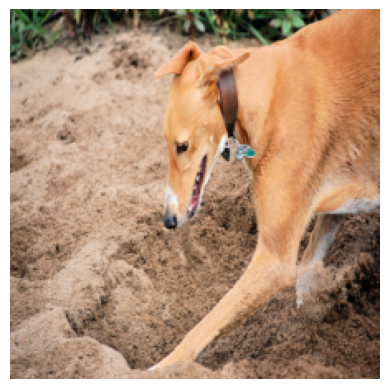

--------------------

best BLEU2 0.36788, (BLEU1 0.36788, BLEU3 0.00000, BLEU4 0.00000): 
predicted caption: 
['a', 'man', 'on', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions:
 
['<start>', 'a', 'biker', 'bikes', 'in', 'the', 'mountains', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'male', 'bicyclist', 'on', 'a', 'mountain', 'road', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'man', 'biking', 'in', 'front', 'of', 'mountains', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'man', 'is', 'biking', 'down', 'really', 'rough', 'terrain', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'man', 'on', 'bicycle', '<unk>', 'high', 'in', 'the', 'mountains', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


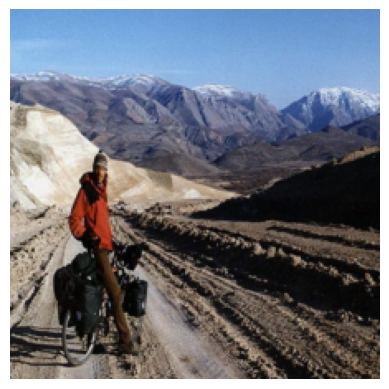

--------------------

best BLEU1 1.00000, (BLEU2 0.00000, BLEU3 0.00000, BLEU4 0.00000),: 
predicted caption: 
['a', 'and', 'dog', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 

['<start>', 'a', 'dog', 'jumps', 'onto', 'the', 'sidewalk', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'small', 'dog', 'runs', 'from', 'the', 'dirt', 'onto', 'the', 'street', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'dog', 'leaps', 'out', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'the', 'brown', 'and', 'white', 'dog', 'is', 'standing', 'on', 'its', 'hind', 'legs', 'beside', 'the', 'path', '<end>']
['<start>', 'a', 'dog', 'jumps', 'onto', 'the', 'sidewalk', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


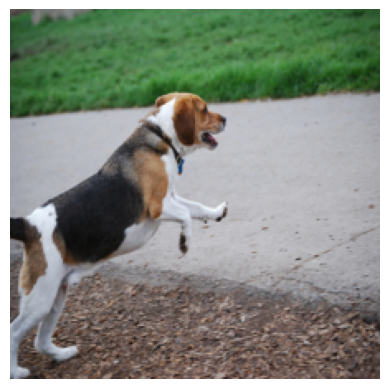

worst BLEU1 0.00000, (BLEU2 0.00000,BLEU3 0.00000,BLEU4 0.00000): 
predicted caption: 
['there', 'two', 'young', 'pink', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

reference captions: 

['<start>', 'a', 'man', 'in', 'a', 'yellow', 'boat', 'paddling', 'against', 'waves', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'person', 'in', 'a', 'yellow', 'kayak', 'is', 'paddling', 'through', 'a', 'river', 'with', 'snowy', '<unk>', '<end>']
['<start>', 'the', 'kayaker', 'is', 'going', 'through', 'rapids', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'the', 'man', 'is', 'in', 'a', 'yellow', 'kayak', 'in', 'rough', 'waters', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'this', 'person', 'in', 'a', 'yellow', 'kayak', 'is', 'riding', 'the', 'rapids', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']


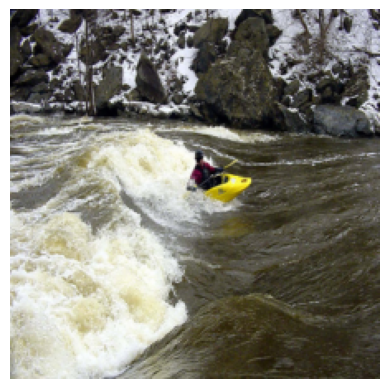

-   Model could learn and generalize well the pattern " a xx(color) dog" as in model V1
-   The first example in the validset and second example in testset are not dog relevant theme. I think it may indicate, fine-tuning embeddings help the model to learn more effective on different patterns and less dominant on a few highest frequent patterns. Or it could be just randomacy.

## 5.4 Compare two models

In [ ]:
# load the reports including model V1 (blue) and V2 (red), solid line for trainset and dashed line for validset
url = "https://wandb.ai/weiping-zhang/dl_mc2/reports/V1-blue-V2-red---Vmlldzo4MjcwMzc0"
IFrame(url, width=1000, height=500)

-   In general, both models have relatively low BLEU scores even on trainset. 

-   Both models could generalize on BLEU1 level, but fail on higher n-grams

-   With fine-tuning GloVe embeddings, model (V2) is slower than directly using pretrained GloVe model. As the model needs the first few epochs to adjust these weights to stabilize and adapt to the specific features of the my dataset. In the upper plots, after around 28 epochs, the two models reached similar values of train loss, BLEU2, BLEU3, BLEU4. 

-   With fine-tuning embeddings (V2), model performance on trainset BLEU1 is better than model with pre-trained embeddings (V1). But it is also more overfitting, as the embedding parameters are trained to fit even on trainset specific details, therefore fails to generalize on unseen data.

-   The valid BLEU2 of model V2 (red) are increasing slightly faster than model V1 at around epoch 27. This tells, fine-tuning the embeddings could potentially improve the model performance to fit better on specific tasks. However, if the dataset is too small and very diverse, fine-tuning embeddings could also lead stronger overfitting.


# 6 Compare two optimal models (with pre-trained vs self-trained embeddings)

In [ ]:
bleu1_values = [0.67, 0.39, 0.57, 0.32]
bleu4_values = [0.023, 0, 0.012, 0]
labels = ['pre-trained Trainset', 'pre-trained Testset', 'self-trained Trainset', 'self-trained Testset']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# BLEU1 
ax1.bar(labels, bleu1_values, color='skyblue')
ax1.set_title('Average BLEU1 Scores')
ax1.set_ylabel('Scores')
ax1.tick_params(axis='x', rotation=45)

# BLEU4 
ax2.bar(labels, bleu4_values, color='salmon')
ax2.set_title('Average BLEU4 Scores')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The two optimal models show very similar trend of loss, BLEU1, and BLEU4, where overall performance of model with pretrained embeddings is better than with self-trained embeddings.

- At around 19th epoch, both models reach the peak BLEU1 scores on validation data. The rise of validation losses indicates that the models are trending overfitting. Models at the epoch with the peak BLEU1 scores are considered as the optimal and are used to further evaluate on unseen data.
- Models still have capacity and potential to learn better on trainset. By implementing additional regularization methods, the models may generalize better on validation and other unseen dataset.
- Both optimal models could capture key features from images on both train and unseen dataset. But the captions on unseen dataset lack natural language sentence structures, this is also reflected on the extremely low BLEU4 scores.



Why are pretrained embeddings better than with self-trained embeddings? 
- The pretrained word embeddings are trained from a large amount of text corpora and are structured to capture complex semantic word relationships. This could provide a significant start in the learning process.
- The pretrained embeddings can help model to train and converge faster because the weights in the embeddings are already optimized. In contrast, the self trained embeddings are initialized with random values and optimized in training process.
- For the datasets are not domain-specific, it is often a better choice to start with pretrained embeddings. They conver broad vocabulary and are ready to use, saving computational resources. For the datasets which are in very special domains or no suitable pretrained embeddings are available, self-trained embeddings may lead accurater captioning.


Potential improvements:
- enhance model generalization: implement regularization and fine tune dropout rates may help to improve the performance on unseen dataset with a possible tradeoff on reduced trainset performance. 
- tune the vocabulary modification process: The vocabulary size, the captions lengths are all decided by this process. Further tune for example the frequency threshold of rare words, ignore less stop words may change the model captioning performance.
- Try other pretrained embedding models such as BERT, GPT which provide contextualized embeddings. They generate captions with consideration of the surrounding context within the sentence. This may lead to a better performance.

In [ ]:
IMPROVEMENT AT END: !!!  ????
- use the captions without unk for training. while still use all 5 captions for BLEU calculation.
- use augmentation for images, so that each reference caption corresponds to an augmented image.
